# Table of Contents
1. [Introduction](#introduction)
2. [Preparing the Dataset](#preparing-the-dataset)

	2.1 [Data Loading and Calibration](#data-loading-and-calibration)

	2.2 [Sample Rate Analysis](#sample-rate-analysis)

	2.3 [Showcasing the Data](#showcasing-the-data)

3. [Statistical Analysis](#statistical-analysis)

	3.1 [Dimensionality Reduction](#dimensionality-reduction)

4. [Discrete Fourier Transform](#discrete-fourier-transform)

	4.1 [Passband Filter](#passband-filter)

	4.1 [Gaussian Filter](#gaussian-filter)

5. [Wavelet Transform](#wavelet-tranform)

	5.1 [Peaks Analysis](#peaks-analysis)

6. [Alternative Methods](#alternative-method)

	6.1 [Subtracting the Baseline](#subtracting-the-baseline)

	6.2 [Finding the Peaks](#finding-the-peaks)

	6.3 [Gaussian Fitting](#gaussian-fitting)

	6.4 [Respiratory Rate](#respiratory-rate-estimation)

# Introduction

The goal of this project is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   

At first we import the libraries we used for the analysis. 

In [1]:
# Libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal
from sklearn.pipeline import Pipeline
from pprint import pprint
from datetime import datetime
from scipy.signal import find_peaks
import pywt
from scipy import stats
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

# Preparing the Dataset

In the this part we prepare the data for the following analysis.

## Data loading and calibration

First of all we load the dataset from one of the following txt files: 
1. * **1_Stave_supine_static.txt**:  
2. * **2_Mattress_supine.txt**: 
3. * **3_Subject_sitting_chair.txt**: 
4. * **4_Chest_sweater.txt**: 
5. * **5_Under_chair.txt**: 
6. * **6_center_sternum.txt**: 

They all present the same data, but with the subject and the sensors in different allocations.

In this notebook we show the results in particular for the sixth file, because the data is token in an ideal case where the MuSe was placed on the center of the sternum and the subject was lying supine on his left and right side, respectively.  

But the code works with any of each files

The columns of these files are:
* Log Freq stands for the acquisition  in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

In [2]:
filenames = ["Data/center_sternum.txt","Data/1_Stave_supine_static.txt","Data/2_Mattress_supine.txt","Data/3_Subject_sitting_chair.txt","Data/4_Chest_sweater.txt","Data/5_Under_chair.txt"]
chosen_file = 4
cuts = [(1129, 14306), (1750, 7999), (1659, 11078), (875, 6109), (500, 12500), (834, 8756)]

In [3]:
# Import the file inside "data" Dataframe
data = pd.read_csv(filenames[chosen_file], sep='\t').reset_index(drop=True)
data.head()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.04878,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.82927,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.48780,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.63420,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.07317,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923


Here we also calibrate the data to ensure that the mesurement obtained from the devices are accurate.  
The function we use to calibrate the data is the following:
$$ \text{DATA}_{\text{calibrated}} = \text{DATA}_{\text{input}} \times \text{CAL}_\text{acc} + \text{OFF} $$  
We find the information about calibration in file README1.txt and README5.txt.

In [4]:
def calibrate(data):
	offset_gyro = np.array([-2.242224, 2.963463, -0.718397])
	calibration_acc = np.array([[1.000966,     -0.002326418,-0.0006995499],
								[-0.002326379,  0.9787045,  -0.001540918],
								[-0.0006995811,-0.001540928, 1.00403]])
	offset_acc = np.array([-3.929942, -13.74679, 60.67546])
	calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
								[-0.02325175, 0.914876, 0.004257396],
								[0.003481006, 0.004257583, 0.8748001]])
	offset_magn = np.array([-95.67974, -244.9142, 17.71132])
	if filenames[chosen_file] != "../Data/center_sternum.txt":
		offset_gyro = np.array([-2.804399, 1.793105, 0.3411708])
		calibration_acc = np.array([[1.002982,    9.415505E-05, 0.004346743],
									[9.04459E-05, 1.002731,    -0.001444198],
									[0.004346536,-0.001444751,  1.030587]])
		offset_acc = np.array([3.602701, -20.96658, 54.97186])
		calibration_magn = np.array([[1.013437,    -0.04728858,  -0.001861475],
									[-0.04728862,  1.004832,    0.008222118],
									[-0.001861605, 0.008221965, 0.9439077]])
		offset_magn = np.array([-150.4098, 74.62431, 630.9805])
	# Apply calibration and offset to respective columns
	data[['GyroX', 'GyroY', 'GyroZ']] += offset_gyro
	data[['AccX', 'AccY', 'AccZ']] = np.dot(data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc
	data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn
	return data

In [5]:
data = calibrate(data)

## Sample Rate Analysis

One of the first thing to do was to chose a proper time window to perform the analysis.
In order to do so we could have 2 ways to procede:
1. Take the frequency of the acquisition of samples stated in the column Log Freq of the file and use it to do a time series, with initialization in time = 0. In this way we would have the acquisition time always the same.
2. Use the timestamp to precisely get the sample frequency.

We decided to check with the timestamps if the hypothesis of constant time acquisition per sample was correct, and also check its real value.

In [6]:
# Cofronting the nominal frequency given in the coloumn with the one we can get from timestamps
couts = data.groupby(["Log Freq"]).count().value_counts()
frequency = data.loc[0, "Log Freq"]
print("The nominal frequency in the Log column is", frequency)
   
acq_per_sec = data.groupby("Timestamp").size()
mean_frequency = np.mean(acq_per_sec)  

print("\nThe total number of acquisitions is: ",data.shape[0])
print("The acquisition time is: ", data["Timestamp"].values.shape[0]/mean_frequency)
print("The mean sampling frequency is: ", round(mean_frequency, 3), "Hz")

percentage_difference = np.abs(frequency - mean_frequency) / frequency * 100
print("The difference in percentage from the nominal frequency to the mean frequency from time stamps is", round(percentage_difference, 2),"%")

The nominal frequency in the Log column is 100

The total number of acquisitions is:  14938
The acquisition time is:  148.0
The mean sampling frequency is:  100.932 Hz
The difference in percentage from the nominal frequency to the mean frequency from time stamps is 0.93 %


When running the code, important data about the sampling are shown.  
The most important things are that the time window of the sampling is of 148 seconds, and also that the nominal frequency given to us in the Log Freq column hasn't the same value of the one we got from timestamps.  
So, since the difference in percentage from the nominal frequency and the one computed from timestamps is 0.93% we also wonder if the frequency is actually constant during the acquisition.

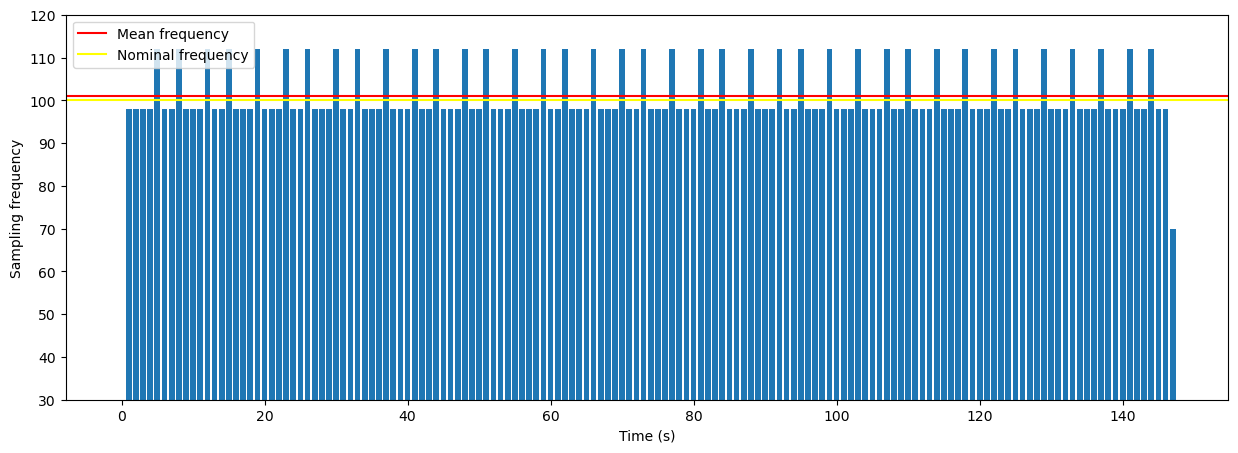

In [7]:
unique_timestamp_counts = data["Timestamp"].value_counts()
num_unique_timestamps = len(unique_timestamp_counts)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(num_unique_timestamps), acq_per_sec)
ax.axhline(mean_frequency, color="red", label="Mean frequency")
ax.axhline(100, color="yellow", label="Nominal frequency")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Sampling frequency")
ax.set_ylim(30, 120)
ax.legend();

We see from te plot that the sampling frequency isn't the same on all seconds, but varies a lot.
The red line is the frequence got from timestamps, the yellow one is the nominal frequency.

Since it seemed more accurate, we used the derived frequency to construct the time window of the data. 
The unit of time is the second, and in particular till the 6th decimal digit.

In [8]:
# we also see that in total we have 16492 rows, so we insert a coloumn with time
data.insert(2, "Time", np.arange(0, data.shape[0]) * (1 / mean_frequency), allow_duplicates=False)

## Showcasing the data

In [9]:
# define the column groups
column_groups = {
    "Accelerometer": ["AccX", "AccY", "AccZ"],
    "Gyroscope": ["GyroX", "GyroY", "GyroZ"],
    "Magnetometer": ["MagnX", "MagnY", "MagnZ"],
    "Quaternion": ["qw", "qi", "qj", "qk"]
}

In [10]:
def plot_modified(data, column_groups, window=80, cuts=None, **kwargs):
    """ Function to plot the data divided in sub-groups """
    # Create subplots for each group
    fig, axs = plt.subplots(len(column_groups), 1, figsize=(15, 10), sharex=False)
    
    
    # iterate through column groups and plot all columns in the same graph for each group
    for i, (group_name, columns) in enumerate(column_groups.items()):
        data.plot(ax=axs[i], x="Time", y=columns, title=group_name)
        axs[i].plot()
        axs[i].set_ylabel(group_name)
        if "xlim" in kwargs:
            axs[i].set_xlim(kwargs["xlim"])
        axs[i].set_xlabel("Time [s]")
        axs[i].legend(loc='upper center', ncols=6)

        if cuts != None: 
            assert type(cuts) == tuple, "Cuts must be a tuple"
            axs[i].axvspan(data["Time"][cuts[0]], data["Time"][cuts[1]], color="lightblue")

    # adjust layout for better readability
    plt.tight_layout()


In [11]:
# Cutting the start and the end of the dataset
cleaned_data = data[cuts[chosen_file][0]: cuts[chosen_file][1]].reset_index(drop=True)
cleaned_data.tail()

,Log Mode,Log Freq,Time,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
11995,5,100,123.795689,1555415447,-794.381601,-107.654503,665.447818,-4.999521,2.158959,0.707024,-29.786832,115.159281,519.760570,0.007051,-0.458235,-0.036378,0.888058
11996,5,100,123.805596,1555415447,-795.637073,-100.079476,672.220829,-4.877570,2.280910,1.072878,-27.761820,115.072926,520.700754,0.008937,-0.458205,-0.036348,0.888058
11997,5,100,123.815504,1555415447,-791.234311,-100.282142,686.196127,-5.243423,1.915056,0.707024,-29.743267,114.170893,521.640163,0.005824,-0.457808,-0.036012,0.888302
11998,5,100,123.825412,1555415447,-791.141402,-104.085124,693.808619,-4.999521,2.280910,0.463122,-29.790555,115.175725,521.648385,0.006296,-0.456801,-0.035920,0.888821
11999,5,100,123.835319,1555415447,-795.015103,-106.423815,703.790662,-5.121472,3.012617,0.585073,-26.793810,116.022247,519.763207,0.007949,-0.456587,-0.036042,0.888913


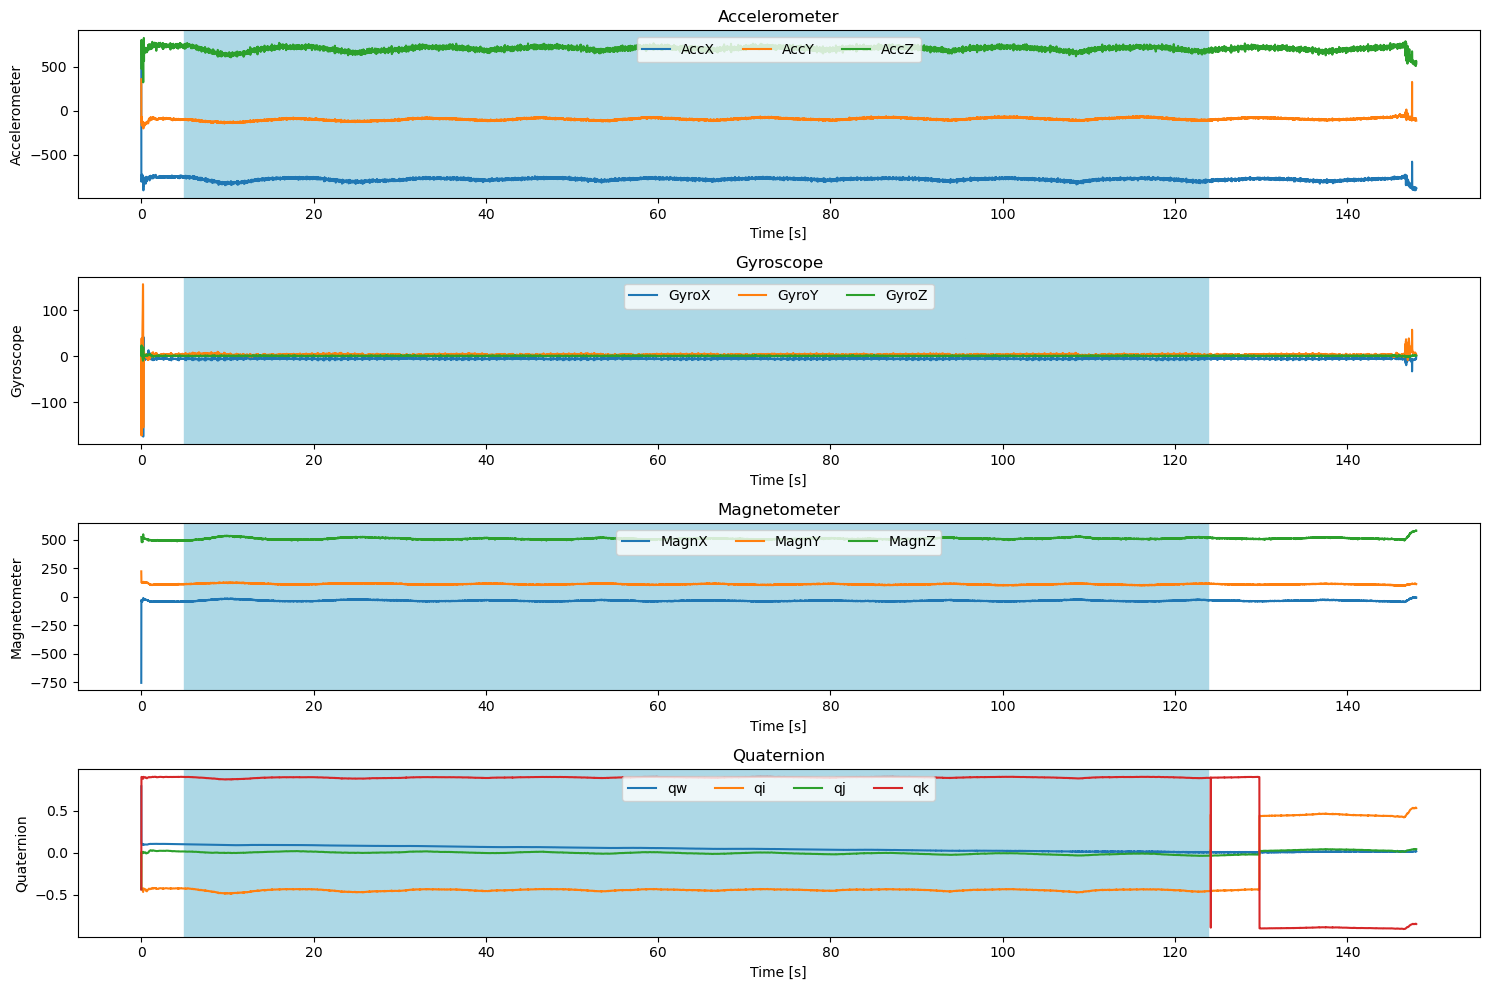

In [12]:
plot_modified(data, column_groups, cuts=cuts[chosen_file])

We see that at the beginning and at the end of the data set there is a lot of noise, maybe caused to the fact that the subject wasn't yet still when the sensors of MUSE activated.  
So in order to do a proper data analys we need to clean the dataset: to do so we take only the central N rows of the data-frame.  
You can look at the plot over that we dropped only the data of the noise.  
For this file we select the rows between (500, 12500).

Later here we can find a zoom of the plots of the features in different ranges.  
The first in 10 seconds, from 30s to 40s.  
The second in 1 second, from 35s to 36s.

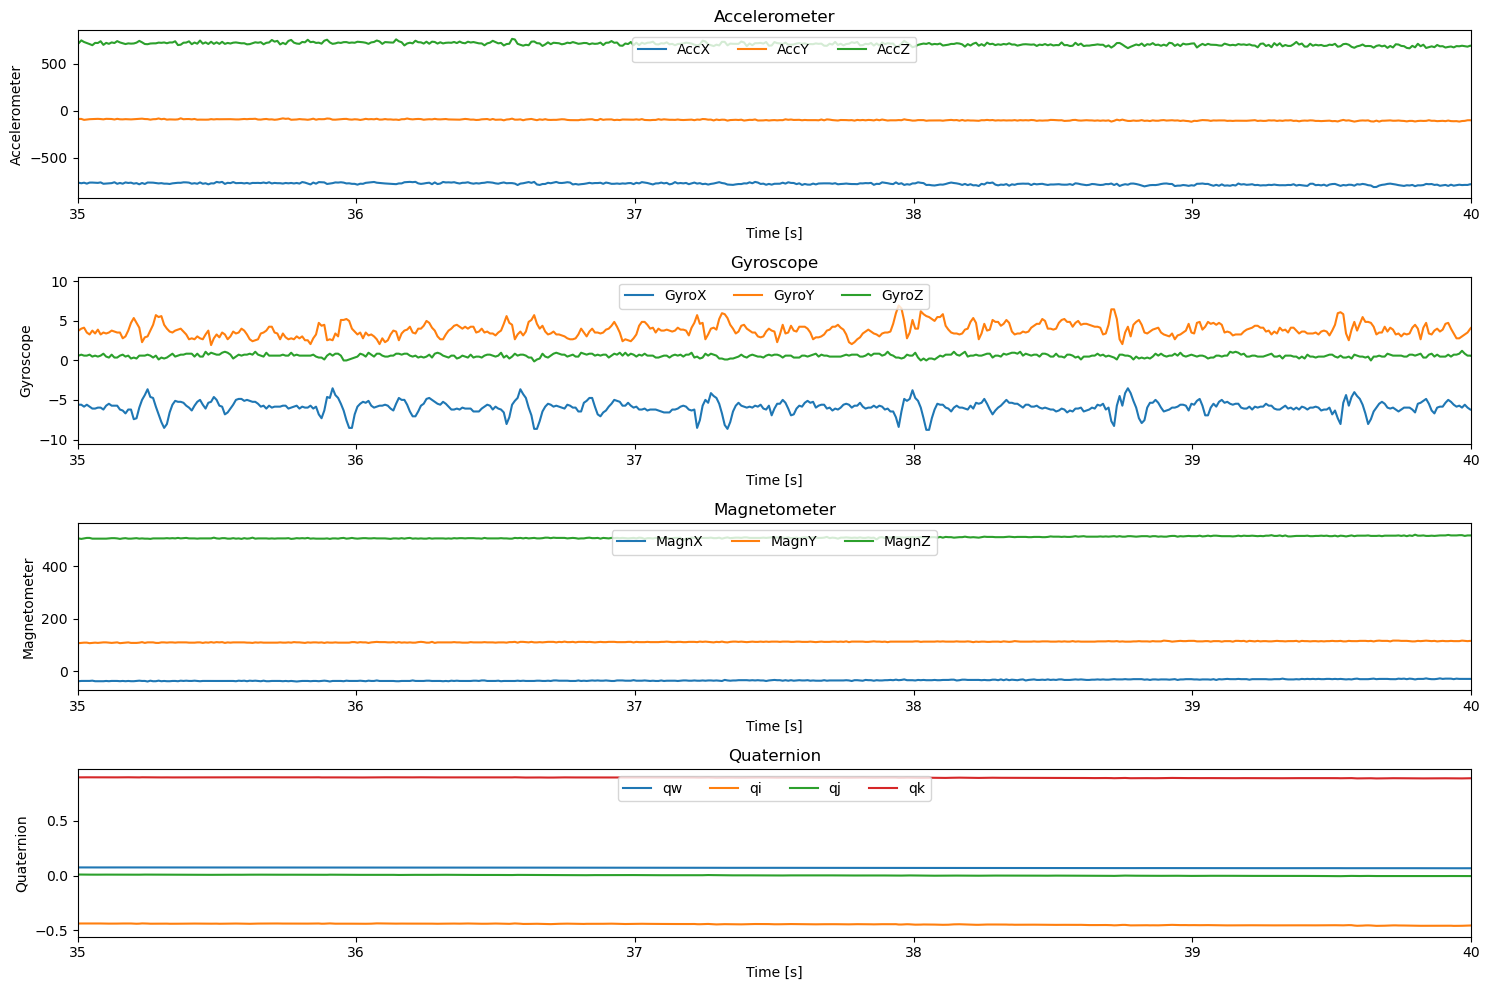

In [13]:
plot_modified(cleaned_data, column_groups, xlim=(35, 40))

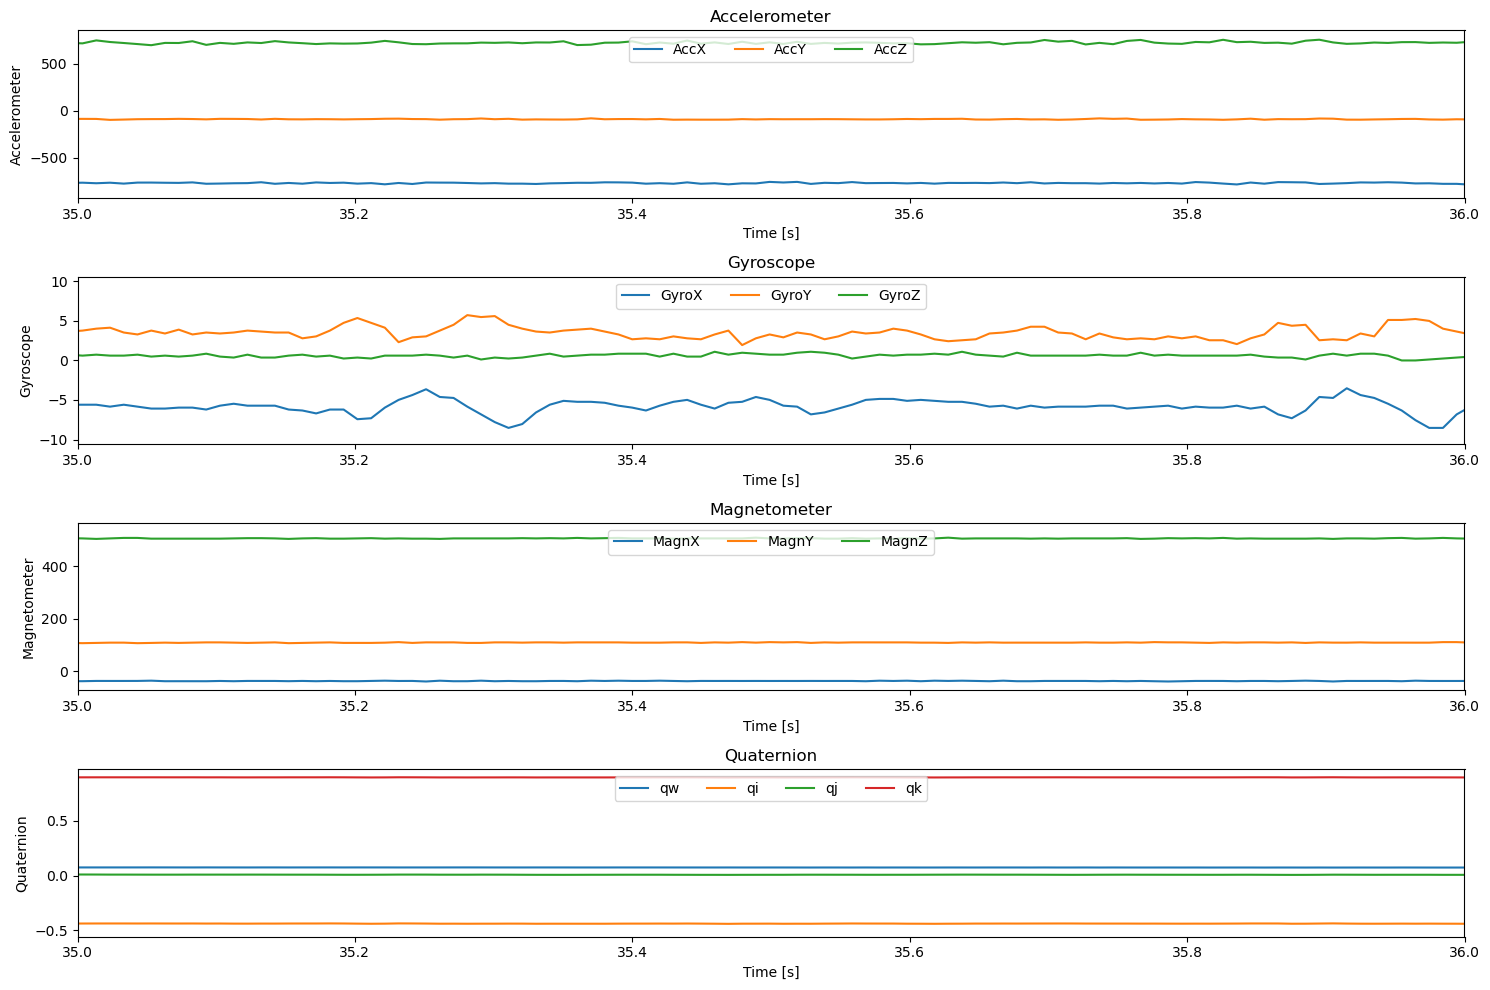

In [14]:
plot_modified(cleaned_data, column_groups, xlim=(35, 36))

Looking at the plots we can see that Magnometer and quaternios are essentially linear functions (except a really low order), decreasing and increasing respectively, their values.  
While the plots of Accelerometer and Gyroscope are more dense of features, and aslo seems to show some kind of periodic behaviour.  
So we expect these to be more important in the following analysis.

# Statistical Analysis
Here we intend to do a preliminary analysis of the dataset, showing the main statistical properties of the properties studied. We also look for the possible correlations among them to ease the following analysis.

In [15]:
data_for_analysis = cleaned_data.drop(columns=["Log Freq","Log Mode", "Time", "Timestamp"])
description = data_for_analysis.describe()
description = pd.concat([description, pd.DataFrame(data_for_analysis.median(axis=0), columns=['median']).T])
description = pd.concat([description, pd.DataFrame(data_for_analysis.std(axis=0)**2, columns=['variance']).T])
print(description[data_for_analysis.columns[:5]])
print(description[data_for_analysis.columns[5:10]])

                  AccX          AccY          AccZ         GyroX         GyroY
count     12000.000000  12000.000000  12000.000000  12000.000000  12000.000000
mean       -782.339850    -95.986661    707.832450     -5.635486      3.356621
std          14.922663     14.532572     23.397208      0.818525      1.017772
min        -849.150379   -145.278184    609.693162     -9.633667     -1.133724
25%        -791.268654   -105.695033    694.425598     -6.097082      2.768715
50%        -779.459811    -95.742480    711.531438     -5.609277      3.256520
75%        -771.557493    -85.053098    724.189979     -5.121472      3.988227
max        -740.557246    -61.608498    774.745622     -2.438545      9.597983
median     -779.459811    -95.742480    711.531438     -5.609277      3.256520
variance    222.685860    211.195643    547.429331      0.669983      1.035860
                 GyroZ         MagnX         MagnY         MagnZ            qw
count     12000.000000  12000.000000  12000.000000  

In [16]:
print(description[data_for_analysis.columns[10:]])

                    qi            qj            qk
count     12000.000000  12000.000000  12000.000000
mean         -0.445451     -0.005980      0.893295
std           0.010902      0.012207      0.006060
min          -0.487381     -0.038240      0.868648
25%          -0.451460     -0.013733      0.890439
50%          -0.442457     -0.004669      0.895108
75%          -0.437178      0.002350      0.897671
max          -0.423322      0.019562      0.902310
median       -0.442457     -0.004669      0.895108
variance      0.000119      0.000149      0.000037


In [17]:
correlations = data_for_analysis.corr()
print(correlations)

           AccX      AccY      AccZ     GyroX     GyroY     GyroZ     MagnX  \
AccX   1.000000  0.721397  0.750390 -0.029563  0.015158 -0.001160 -0.867654   
AccY   0.721397  1.000000  0.723543  0.006444 -0.059569 -0.017186 -0.848842   
AccZ   0.750390  0.723543  1.000000 -0.024643 -0.034046 -0.038230 -0.824516   
GyroX -0.029563  0.006444 -0.024643  1.000000 -0.513640  0.489971  0.028995   
GyroY  0.015158 -0.059569 -0.034046 -0.513640  1.000000 -0.528176 -0.002949   
GyroZ -0.001160 -0.017186 -0.038230  0.489971 -0.528176  1.000000  0.027111   
MagnX -0.867654 -0.848842 -0.824516  0.028995 -0.002949  0.027111  1.000000   
MagnY -0.727000 -0.945629 -0.715238  0.019367  0.041706  0.017839  0.868616   
MagnZ -0.869491 -0.670932 -0.805853  0.027039 -0.028887  0.021935  0.915210   
qw    -0.027736 -0.470748 -0.106074  0.035577  0.033285  0.054689  0.192407   
qi     0.891078  0.817368  0.855920 -0.029315 -0.005524 -0.024695 -0.973536   
qj     0.394174  0.050678  0.302771  0.044345 -0.000

## Dimensionality Reduction

Before trying to extrapolate the heartbeat from the data, we perform a dimensionality reduction via PCA to identify the most important feature (or combination of features) to analyze, as analyzing all the features would be wasteful and inefficient.

In [18]:
## Pre-processing data: dropping columns and scaling
data_for_analysis = cleaned_data.drop(columns=["Log Freq","Log Mode", "Time", "Timestamp"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_analysis)

In [19]:
# The PCA is instantiated
pca = PCA()
# and then computed
data_after_pca = pca.fit_transform(scaled_data)

As the PCA returns the new features in ascending order of variance, we want to keep only the first $n$ components. $n$ is determined as the minimum number of components to retain a total of $90\%$ variance. 

PCA tells us that 3 features retain 90% variance


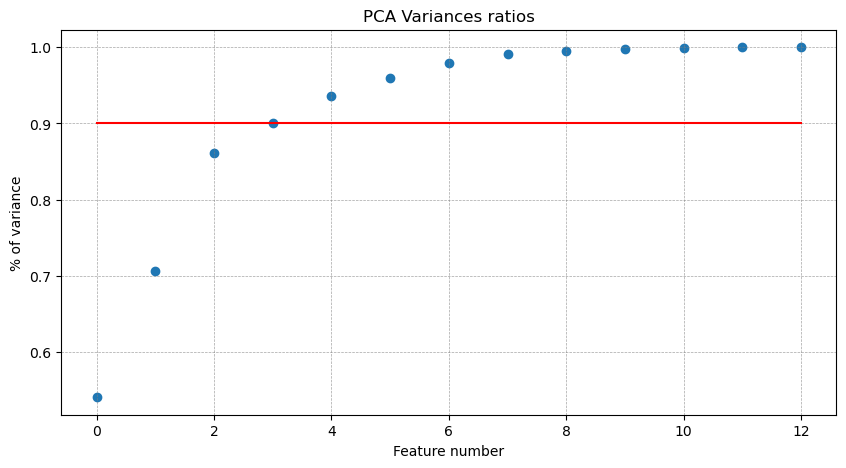

In [20]:
# The variance ratios of the new features is extracted from the PCA object
PCA_Variances_Ratios = np.cumsum(pca.explained_variance_ratio_)

# A plot is made to better visualize how many features to use
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.scatter(np.arange(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
ax.set_title("PCA Variances ratios")
ax.set_ylabel("% of variance")
ax.set_xlabel("Feature number")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.plot(np.arange(len(pca.explained_variance_ratio_)),np.ones(len(pca.explained_variance_ratio_))*0.9,color="red")
most_important_features_number = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)
print(f"PCA tells us that {most_important_features_number} features retain 90% variance")

We check here if the PCA was successful, using a t-student test to observe the significance of the correlations. We set a reasonable treshold under wich we can safely claim the t-student's test was not passed.

In [21]:
correlations = np.corrcoef(data_after_pca.T)
for i in range(correlations.shape[0]):
    correlations[i,i]=0 
t = np.abs(correlations)*np.sqrt((len(data_after_pca)-2)/(1-correlations**2))
print("The number of pairs that are highly correlated are", t[np.abs(t)>1e-3].shape[0])

The number of pairs that are highly correlated are 0


Because the t-student is very little, we can make the assumption the data is actually fairly uncorrelated, and thus procede with the analysis.

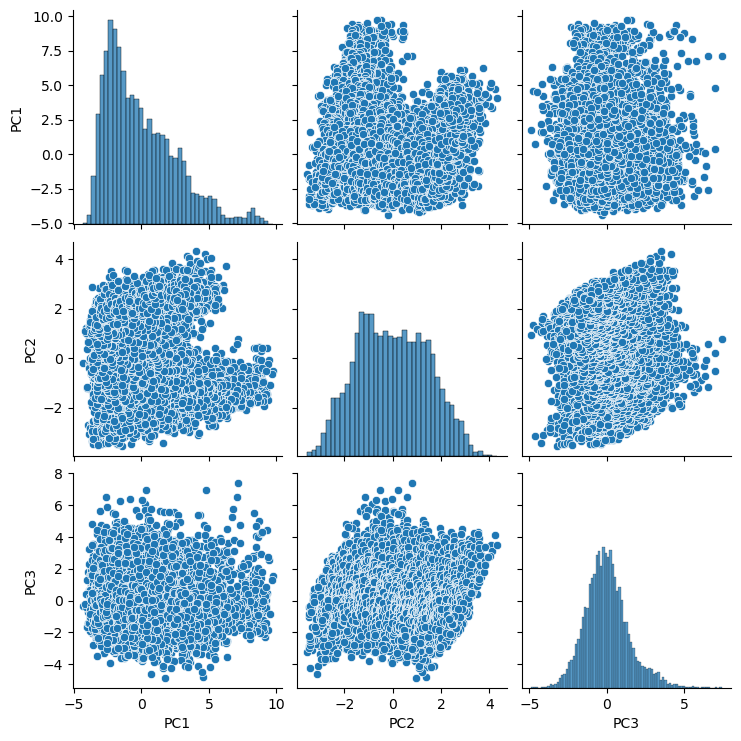

In [22]:
# Pairplot to visualize the data
sns.pairplot(pd.DataFrame(data_after_pca[:,0:most_important_features_number],columns=[f"PC{i+1}" for i in range(most_important_features_number)]));

# Discrete Fourier Transform

The Discrete Fourier Transform (DFT) converts a finite sequence sample of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier Transform (a complex-valued function of the frequency). The main relevant assumption is that the original function is equally spaced itself. 

$X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi \frac{k}{N}n}$

The Fast Fourier Transform (FFT) is a power algorithm to compute the DFT (and its inverse) that runs in $O(n \log n)$, providing a great computational advantage over the $O(n^2)$ of the naive implementation. 

We performed the FFT over all relevant pricipal components to investigate the frequency spectrum.

We can clearly see two peaks:
* First peak: around $0.2$ Hz (i.e. $12$ BPM), it refers to the respiratory rate. 
* Second peak: around $1.2$ Hz (i.e. $72$ BPM), it's related to the heart rate, our feature of interest. In an healthy adult at rest, the typical beat rate is between $40$ and $100$ BPM. 

We can also notice some high-frequency noise that could interfere with our analysis. 

In [23]:
# Get the most relevant principal components
data_after_pca_only_most_important_feature = data_after_pca[:,0:most_important_features_number]
N = len(data_after_pca)

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_after_pca_only_most_important_feature, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/mean_frequency))

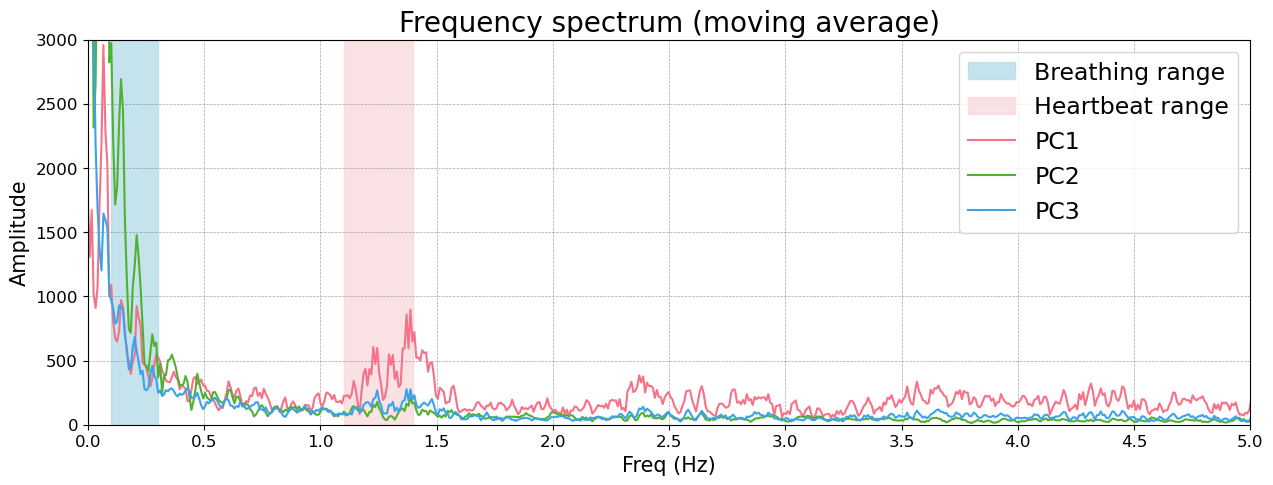

In [24]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

ax.axvspan(0.1, 0.3, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heartbeat range")

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=17, loc="upper right");

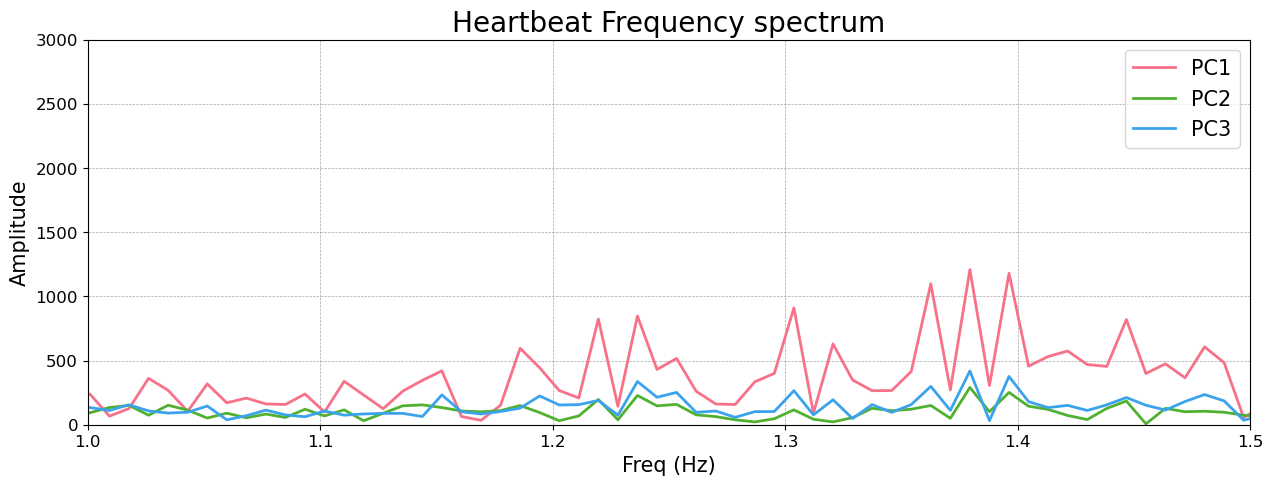

In [25]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies, np.abs(sig_fft[:, i]), lw=2, color=color, label="PC"+str(i+1))

ax.set_xlim(1.0, 1.5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Heartbeat Frequency spectrum", fontsize=20)
ax.legend(fontsize=15);

## Filters
### Passband Filter
To isolate the frequencies we are interesting in, we made a bandpass filter between $1.1$ and $1.4$ Hz. This means to filtered out most of the unwanted frequencies, but some noise is mantained. 

By antitrasforming the data, we can obtain a periodical time-series. Its frequency is an estimate of hearth rate itself. 

It is important to notice that the DTF integrate the temporal information, so it's a steady procedure and the temporal variabily of its inverse refers to the noisy spectrum. 

In [26]:
# Filter the spectrum
filtered_sig_fft = sig_fft.copy()
filtered_sig_fft[(np.abs(frequencies) < 1.1) | (np.abs(frequencies) > 1.4)] = 0

# Antitrasformed the spectrum
inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(filtered_sig_fft), axis=0)

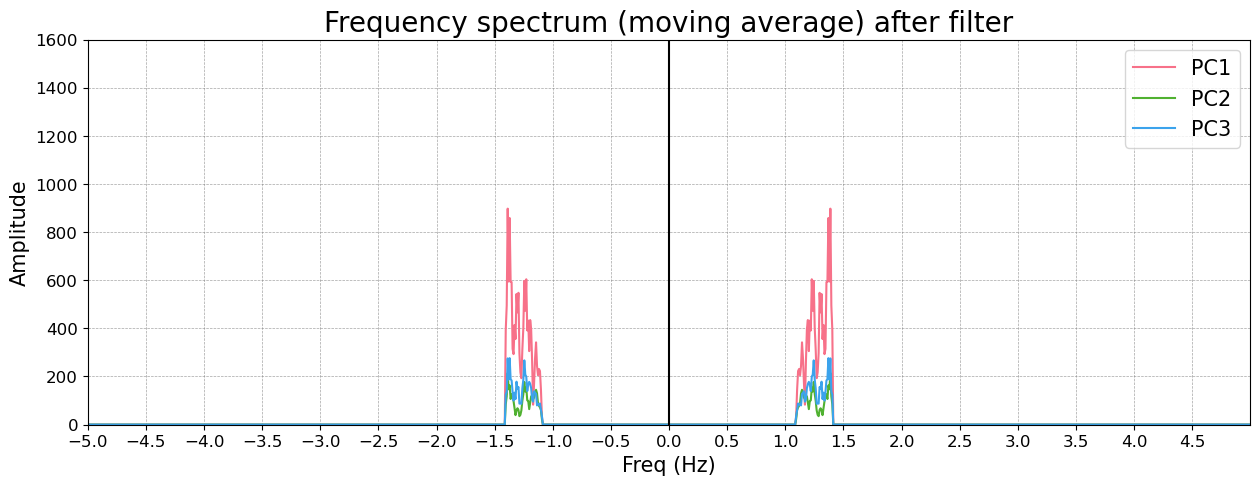

In [27]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(filtered_sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 1600)
ax.xaxis.set_ticks(np.arange(-5, 5, 0.5))
ax.vlines(0, -0.5, 1600, color="black")
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average) after filter", fontsize=20)
ax.legend(fontsize=15);

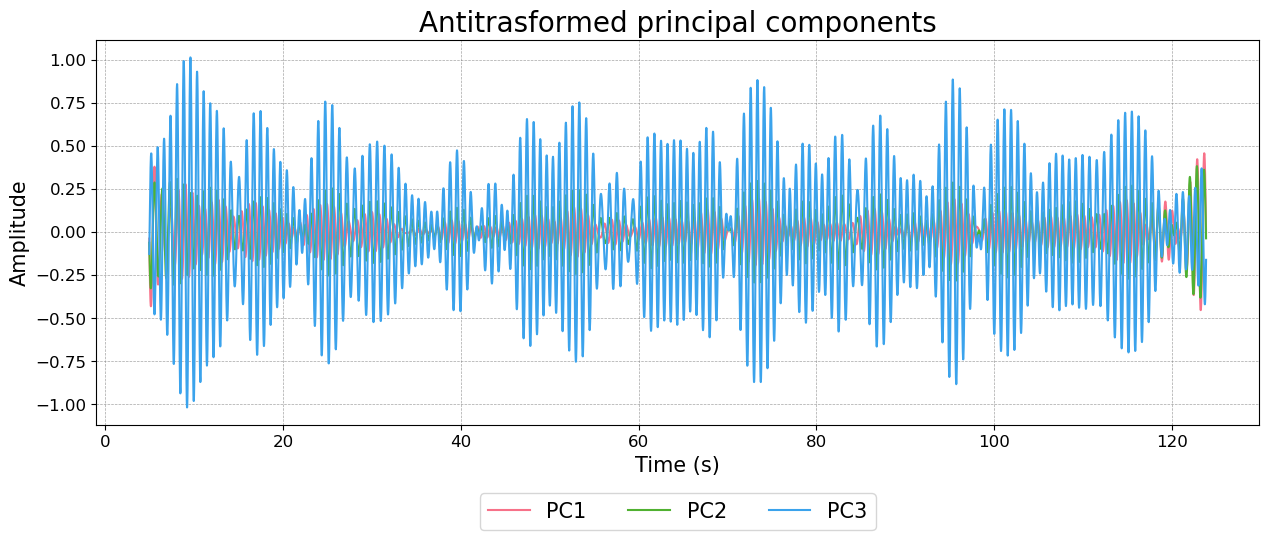

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(cleaned_data["Time"].values, inversed_sig_fft.real[:, i], color=color, label="PC"+str(i+1))

ax.set_title("Antitrasformed principal components", fontsize=20)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncols = most_important_features_number, fontsize=15)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Time (s)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15);

#### Analyzing the peaks
After the passband filter is applied, the anti-transformed data must be used to extrapolate the frequency, which is expected to be the peak visible in the spectrum.
To do that, the frequency of the peaks is analyzed. Two method are proposed:
1. A "naive" method: the number of peaks is simply divided by the total time to find the mean BPM (each peak is so assumed to be a single hearbeat)
2. The distribution of the periods between two peaks are analyzed (in practice the inverse of the period is used)

As an example, the peaks of the first PCA component are presented below.

BPM computed with naive method is: 77.21 bpm


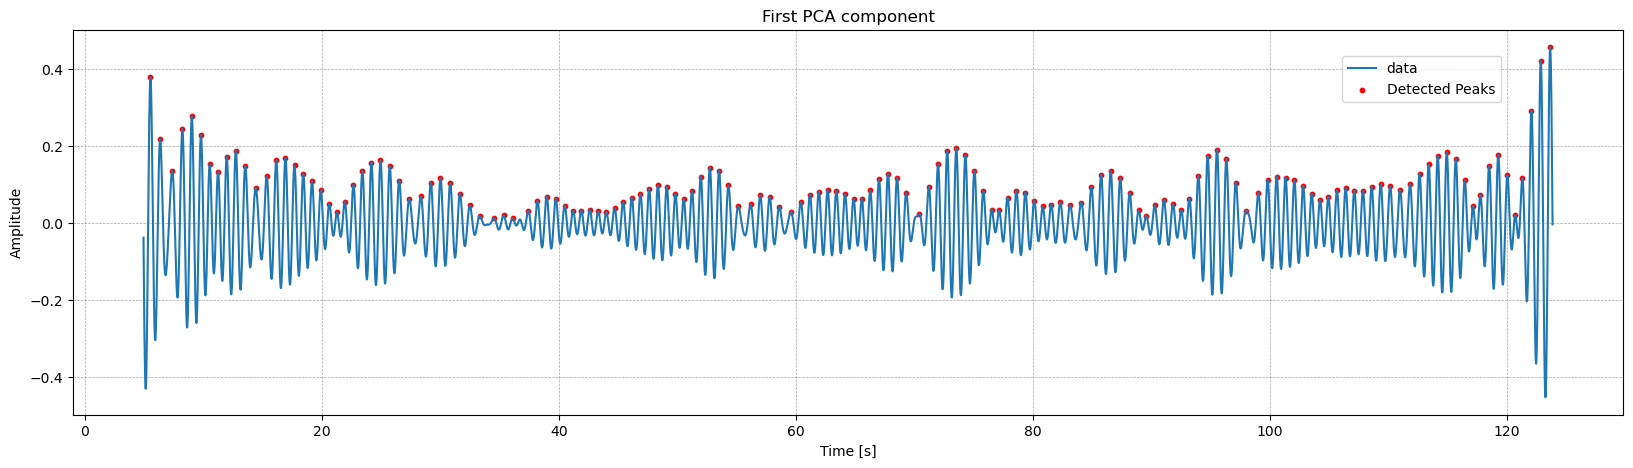

In [29]:
# Results for first PCA component as an example
series = inversed_sig_fft[:,0].real # Define time_series to analyze
peak_index, _ = signal.find_peaks(series,0.01,distance=1,) # Find maxima
BPM = peak_index.shape[0]/(series.shape[0]/mean_frequency)*60 # Calculate BPM with "naive" method
fig, ax = plt.subplots(figsize=(20,5))

ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("First PCA component")
ax.plot(cleaned_data["Time"],series, label="data")
ax.scatter(cleaned_data["Time"][peak_index],series[peak_index],c = "red",s=10,label='Detected Peaks');
print(f"BPM computed with naive method is: {np.round(BPM,2)} bpm")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.legend(loc='upper center', bbox_to_anchor=(0.87, 0.95));

The two methods are then performed on each PCA component. The HRV (Heart Rate Variability) is also computed with the second method.

These are the BPM from each PCA component: [77.21, 78.73, 79.23]
These are the HRV from each PCA component: [7.55, 8.71, 7.33]


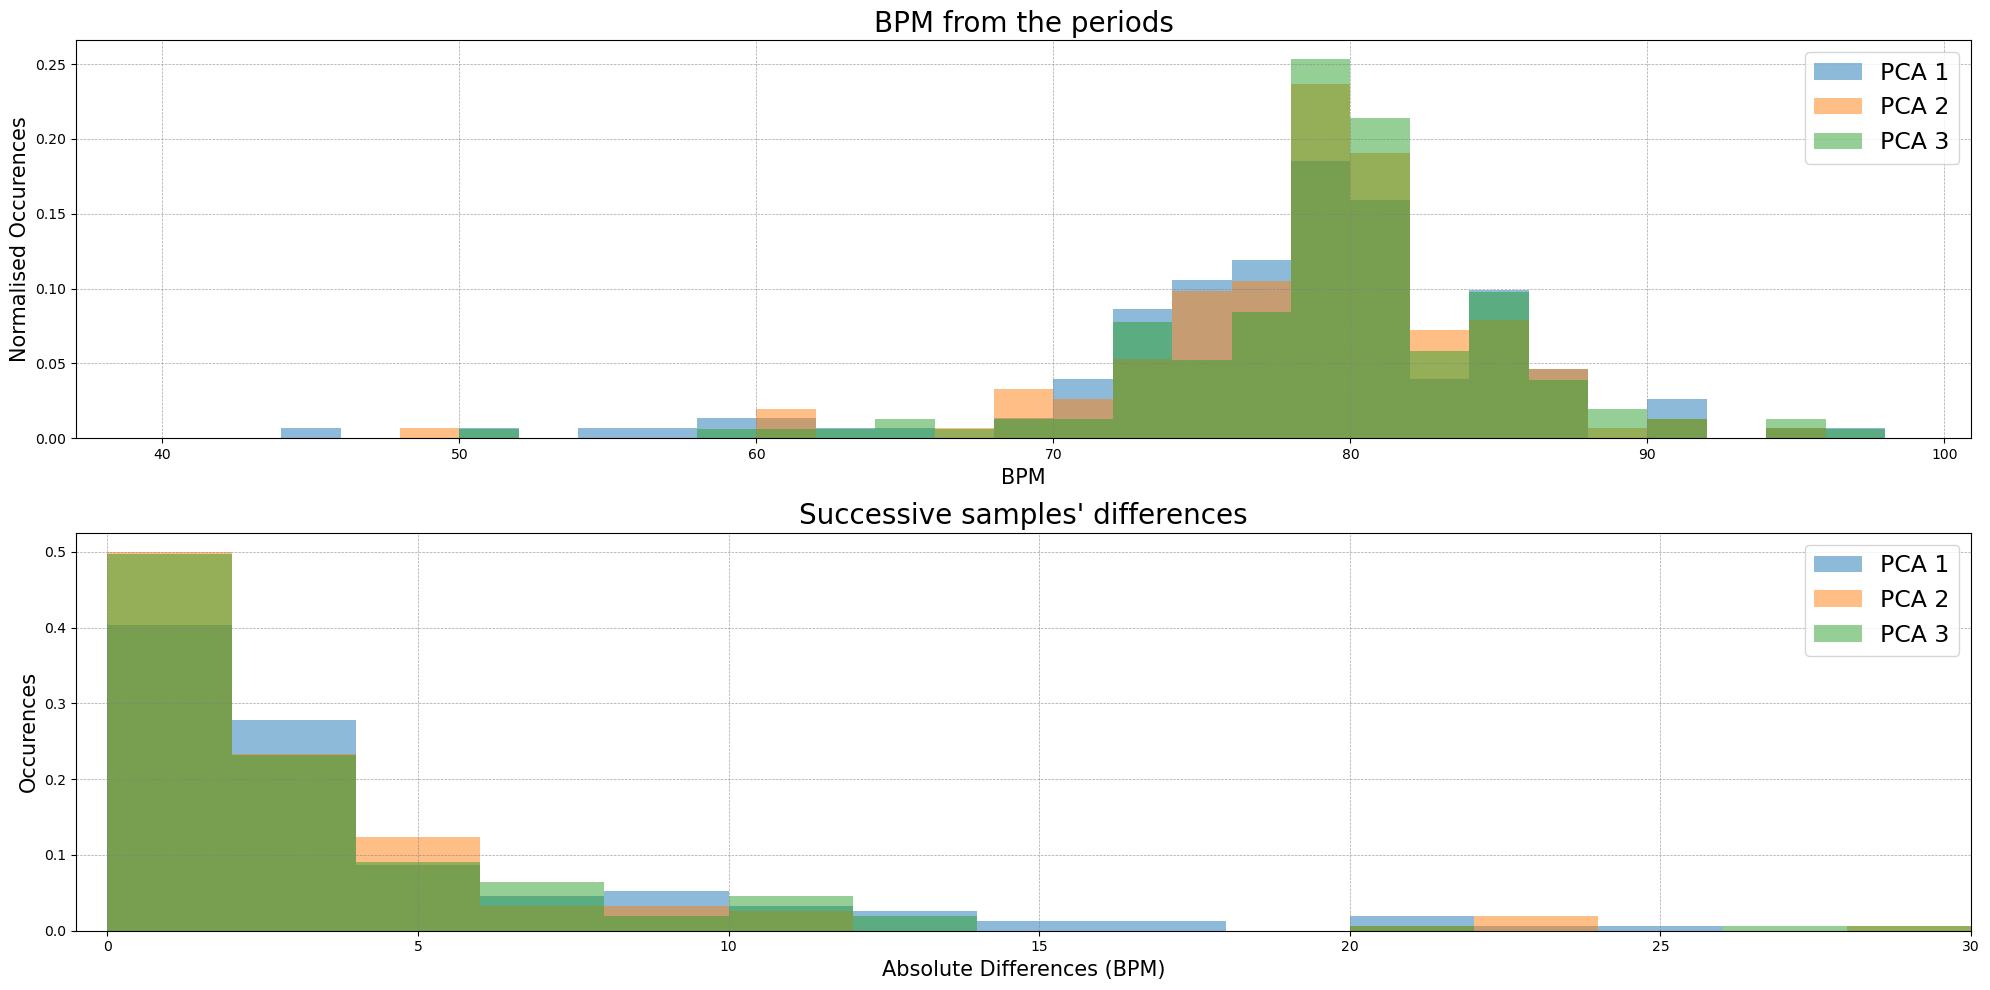

In [30]:
# We only use maxima because using the minima leads to the same results
BPM_naive_list = []
BPM_total = np.array([])
hrv_list = []
# Gaussian Function
gauss = lambda x, A, mu, sigma : A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2)
fig, (ax,bx) = plt.subplots(2,1,figsize=(20, 10))

for i in np.arange(inversed_sig_fft.shape[1]):
    min_dis = 1 # Minimum distance between peaks, in number of samples
    
    series = inversed_sig_fft[:,i].real # Define time_series to analyze
    peak_index, _ = signal.find_peaks(series,0.01,distance=min_dis) # Find maxima
    BPM_naive = peak_index.shape[0]/(series.shape[0]/mean_frequency)*60 # Calculate BPM with "naive" method
    BPM_naive_list.append(np.round(BPM_naive,2))

    # We create a histogram of the BPM from the periods between the peaks
    BPM = mean_frequency/np.array([peak_index[i] - peak_index[i-1] for i in range(1,len(peak_index))])*60
    BPM_total = np.concatenate((BPM_total,BPM))
    bin_edges = np.arange(40,100,step=2)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    h = np.histogram(BPM,bins=bin_edges)
    
    # We fit a Gaussian on the Histogram
    hrv = np.sqrt(np.mean(np.diff(BPM)**2)) # Heart Rate Variability
    hrv_list.append(np.round(hrv,2))
    
    bin_edges = np.arange(0,80,step=2)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    hrv_h = np.histogram(np.abs(np.diff(BPM)),bins=bin_edges)
    bx.set_title("Successive samples' differences", fontsize=20)
    bx.set_xlabel("Absolute Differences (BPM)", fontsize=15)
    bx.set_ylabel("Occurences", fontsize=15)
    bx.bar(hrv_h[1][0:-1],hrv_h[0]/(np.sum(hrv_h[0])),align="edge",width=2,alpha=0.5, label="PCA " + str(i+1))
    bx.legend(fontsize=17)
    bx.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    bx.set_xlim(-0.5, 30)

    # Plot
    ax.bar(h[1][0:-1],h[0]/(np.sum(h[0])),align="edge",width=2,alpha=0.5,label="PCA " + str(i+1))
    #ax.plot(np.linspace(30,150,num=120*40), gauss(np.linspace(30,150,num=120*40),*popt), 'k-', lw=2)
    ax.set_title("BPM from the periods", fontsize=20)
    ax.set_xlabel("BPM", fontsize=15)
    ax.set_ylabel("Normalised Occurences", fontsize=15)
    ax.legend(fontsize=17)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    
fig.tight_layout()
    
print(f"These are the BPM from each PCA component: {BPM_naive_list}")
print(f"These are the HRV from each PCA component: {hrv_list}")
passband_hrv = np.mean(hrv_list)
passband_hrv_std = np.std(hrv_list)

As seen in the plot above, the histograms of all PCA components are very similar (as expected), so they are combined and a gaussian fit is computed.

Total number of sample:  463
The center of the gaussian is 79.46 ± 0.39
The width of the gaussian is 3.73 ± 0.39


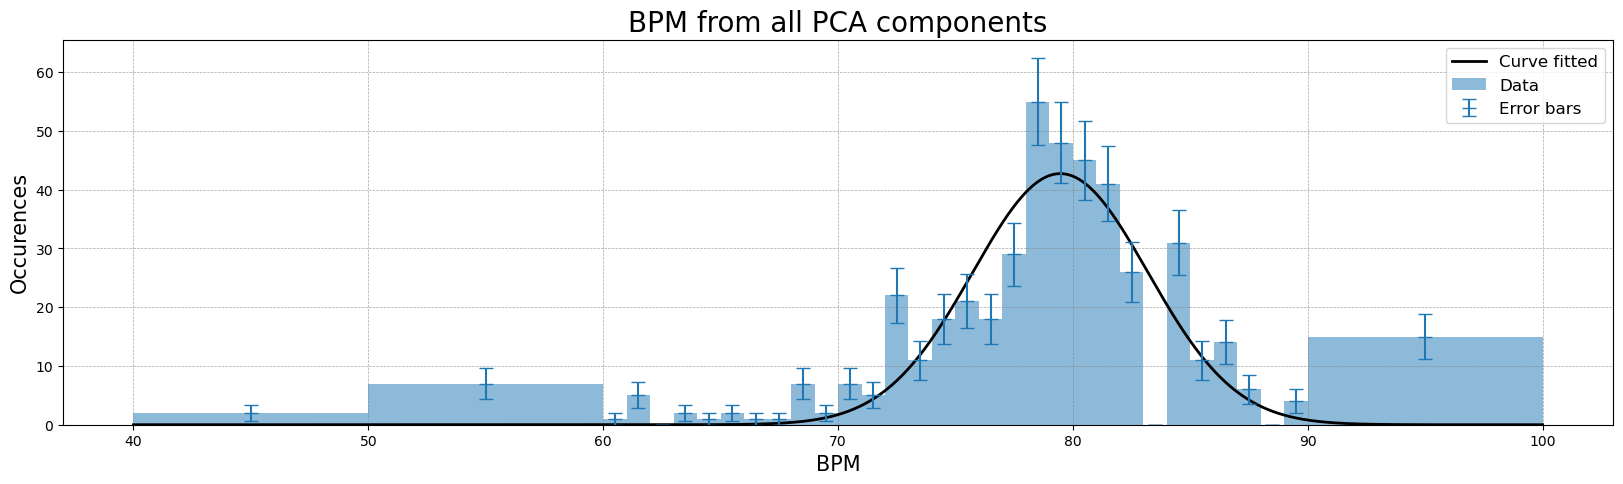

In [31]:
# Total BMP histogram
bin_edges = np.concatenate((np.arange(40,60,step=10),np.arange(60,90,step=1),np.arange(90,110,step=10)))
bin_center = (bin_edges[1:] + bin_edges[:-1])/2
bin_width = bin_edges[1:] - bin_edges[:-1]
h = np.histogram(BPM_total,bins=bin_edges)
popt,pcov = curve_fit(gauss,bin_center,h[0],p0=[10,75,5])

print("Total number of sample: ", BPM_total.shape[0])
print(f"The center of the gaussian is {np.round(popt[1],2)} ± {np.round(np.sqrt(pcov[1,1]),2)}")
print(f"The width of the gaussian is {np.round(popt[2],2)} ± {np.round(np.sqrt(pcov[2,2]),2)}")

fig, ax = plt.subplots(figsize=(20,5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.bar(h[1][0:-1],h[0],align="edge",width=bin_width,alpha=0.5,label='Data')
ax.plot(np.linspace(40,100,num=120*40), gauss(np.linspace(40,100,num=120*40),*popt), 'k-', lw=2, label='Curve fitted')
ax.errorbar(bin_center,h[0],np.sqrt(h[0]),ls="None",capsize=5,marker="_",markersize=10, label='Error bars')
ax.legend(loc='upper right', fontsize=12)
ax.set_title("BPM from all PCA components", fontsize=20)
ax.set_xlabel("BPM", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15);

pcov_bandpass = pcov
popt_bandpass = popt

We can see from the fit of all the frequency extracted that the mean BPM (the two method gives similar results) is: ~80

# Wavelet Transform
A powerful alternative to the DFT is the *wavelet transform*, which overcomes the loss of the temporal information. 

In this project, we used a *Daubechies 6* wavelet. [The literature](https://www.sciencedirect.com/science/article/pii/S174680941930360X?via%3Dihub) suggests this wavelet because of its smooth shape and its similarity to the oscillating pattern of the heartbeat. 

The signal is iteratively divided into the low and high frequency components for $J$ levels. The net result is the list of coefficients $[A_J, \{D_j\}_j]$ with $1 \le j \le J$. Being $f_s$ the original frequency, $A_J$ refers to the frequencies between $0$ and $f_s/2^{J+1}$ while each $D_j$ coefficient refers to the $[f_s/2^{j+1}, f_s/2^{j}]$ range. Our ``get_frequency_ranges()`` function returns the ranges depending on $f_s$ and the used level.

The main limitation of this method is that you cannot choose the frequency range, because of the given discretization. 

We expect the normal beat to be between $[0.67, 1.67]$ Hz. Thus, the coefficient we need is the fifth (frequences between $[0.84, 1.70]$ Hz).


In [32]:
# Perform the multilevel decomposition of the time series
max_level = pywt.dwt_max_level(len(data_after_pca_only_most_important_feature), "db6")
print("Maximum useful level of decomposition for this dataset: " + str(max_level))

coeffs = pywt.wavedec(data_after_pca_only_most_important_feature, "db6", level=max_level, axis=0)

Maximum useful level of decomposition for this dataset: 10


In [33]:
# Helper function to compute the frequency ranges of a wavelet decomposition
def get_frequency_ranges(f_s, level):
    freq = [[0, f_s/2**(level+1)]]

    for j in range(level, 0, -1):
        freq.append([f_s/2**(j+1), f_s/2**(j)])

    return freq

get_frequency_ranges(mean_frequency, max_level)

[[0, 0.04928341427364865],
 [0.04928341427364865, 0.0985668285472973],
 [0.0985668285472973, 0.1971336570945946],
 [0.1971336570945946, 0.3942673141891892],
 [0.3942673141891892, 0.7885346283783784],
 [0.7885346283783784, 1.5770692567567568],
 [1.5770692567567568, 3.1541385135135136],
 [3.1541385135135136, 6.308277027027027],
 [6.308277027027027, 12.616554054054054],
 [12.616554054054054, 25.23310810810811],
 [25.23310810810811, 50.46621621621622]]

We expect the normal beat to be between $[0.67, 1.67] Hz$. The coefficient we need is the fifth (frequences between $[0.78, 1.57]Hz$). We are cutting some boundary frequences.  

In [34]:
# Function to set to zero the unwanted coefficients
def select_coeffs(coeffs, useful_coeffs):
    assert type([0, 1]) == list, "useful_coeffs must be a list"

    for i in range(len(coeffs)):
        if i not in useful_coeffs:
            #Replace with a zero array of the same size
            coeffs[i] = np.zeros_like(coeffs[i])
    
    return coeffs

filtered_coeff = select_coeffs(coeffs, [5])

In [35]:
# Wavelet antitransform
filtered_sig = pywt.waverec(filtered_coeff, "db6", axis=0)

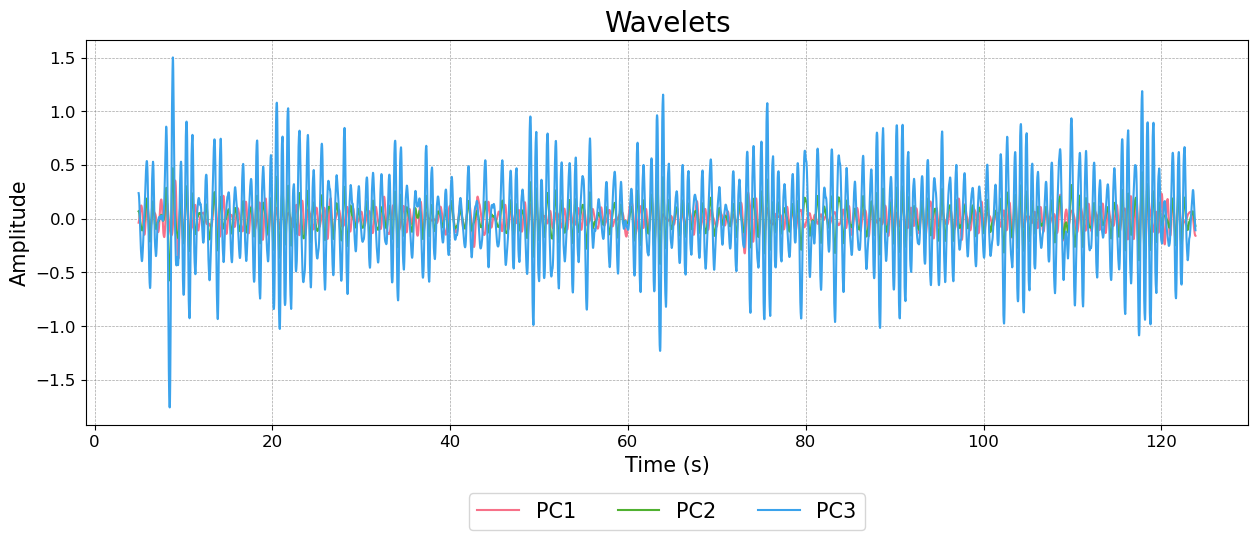

In [36]:
# Plot the wavelet transform of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(cleaned_data["Time"].values, filtered_sig[:, i], color=color, label="PC"+str(i+1))

ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Time (s)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Wavelets", fontsize=20)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncols = most_important_features_number, fontsize=15);


## Peaks Analysis
The same two methods used for the analysis of the data filtered with the passband are used with the wavelet data.

BPM computed with naive method is: 78.22


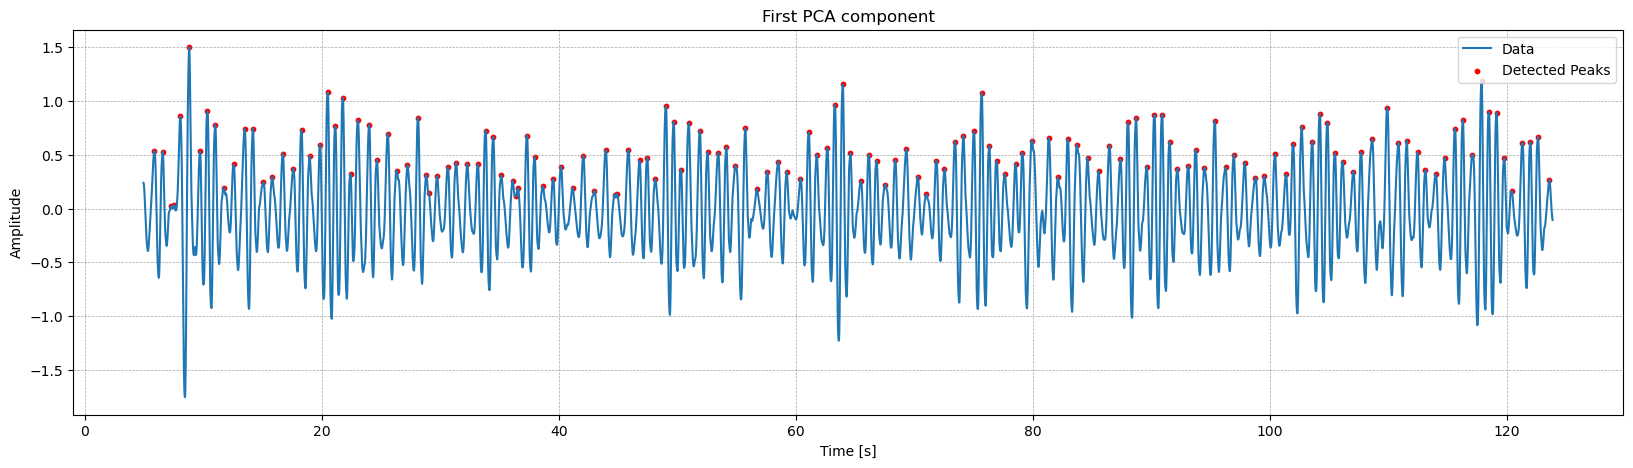

In [37]:
# Results for first PCA component as an example, wavelet case
series = filtered_sig[:,2].real # Define time_series to analyze
peak_index, _ = signal.find_peaks(series,0.01,distance=20,) # Find maxima
BPM = peak_index.shape[0]/(series.shape[0]/mean_frequency)*60 # Calculate BPM with "naive" method
fig, ax = plt.subplots(figsize=(20,5))

ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("First PCA component")
ax.plot(cleaned_data["Time"],series,label='Data')
ax.scatter(cleaned_data["Time"][peak_index],series[peak_index],c = "red",s=10,label="Detected Peaks")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.legend(loc='upper right');
print(f"BPM computed with naive method is: {np.round(BPM,2)}")

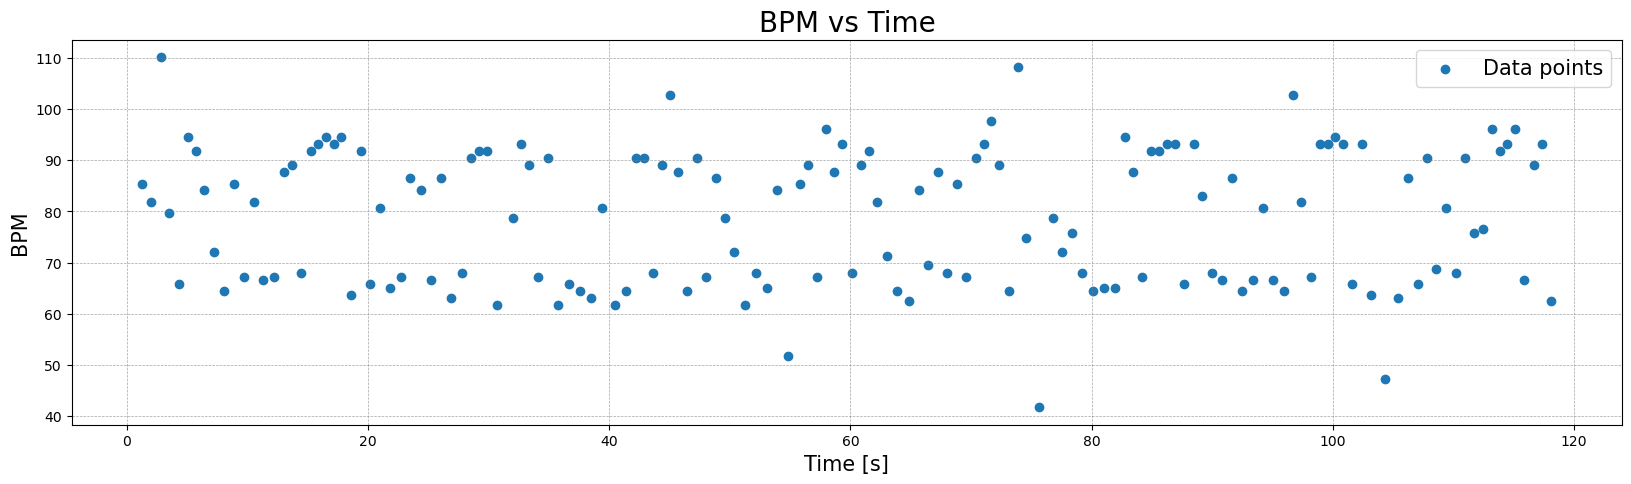

In [38]:
time_center = np.array([(peak_index[i] + peak_index[i-1])/2 for i in range(1,len(peak_index))])/mean_frequency
widths = np.array([(peak_index[i] - peak_index[i-1]) for i in range(1,len(peak_index))])/mean_frequency
BPM = mean_frequency/np.array([peak_index[i] - peak_index[i-1] for i in range(1,len(peak_index))])*60
fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(time_center[BPM<120],BPM[BPM<120],label='Data points')
ax.set_ylabel("BPM", fontsize=15)
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_title("BPM vs Time", fontsize=20)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.legend(loc='upper right', fontsize=15);

These are the BPM from each PCA component: [75.7, 76.71, 78.22]
These are the HRV from each PCA component: [40.83, 29.52, 51.26]


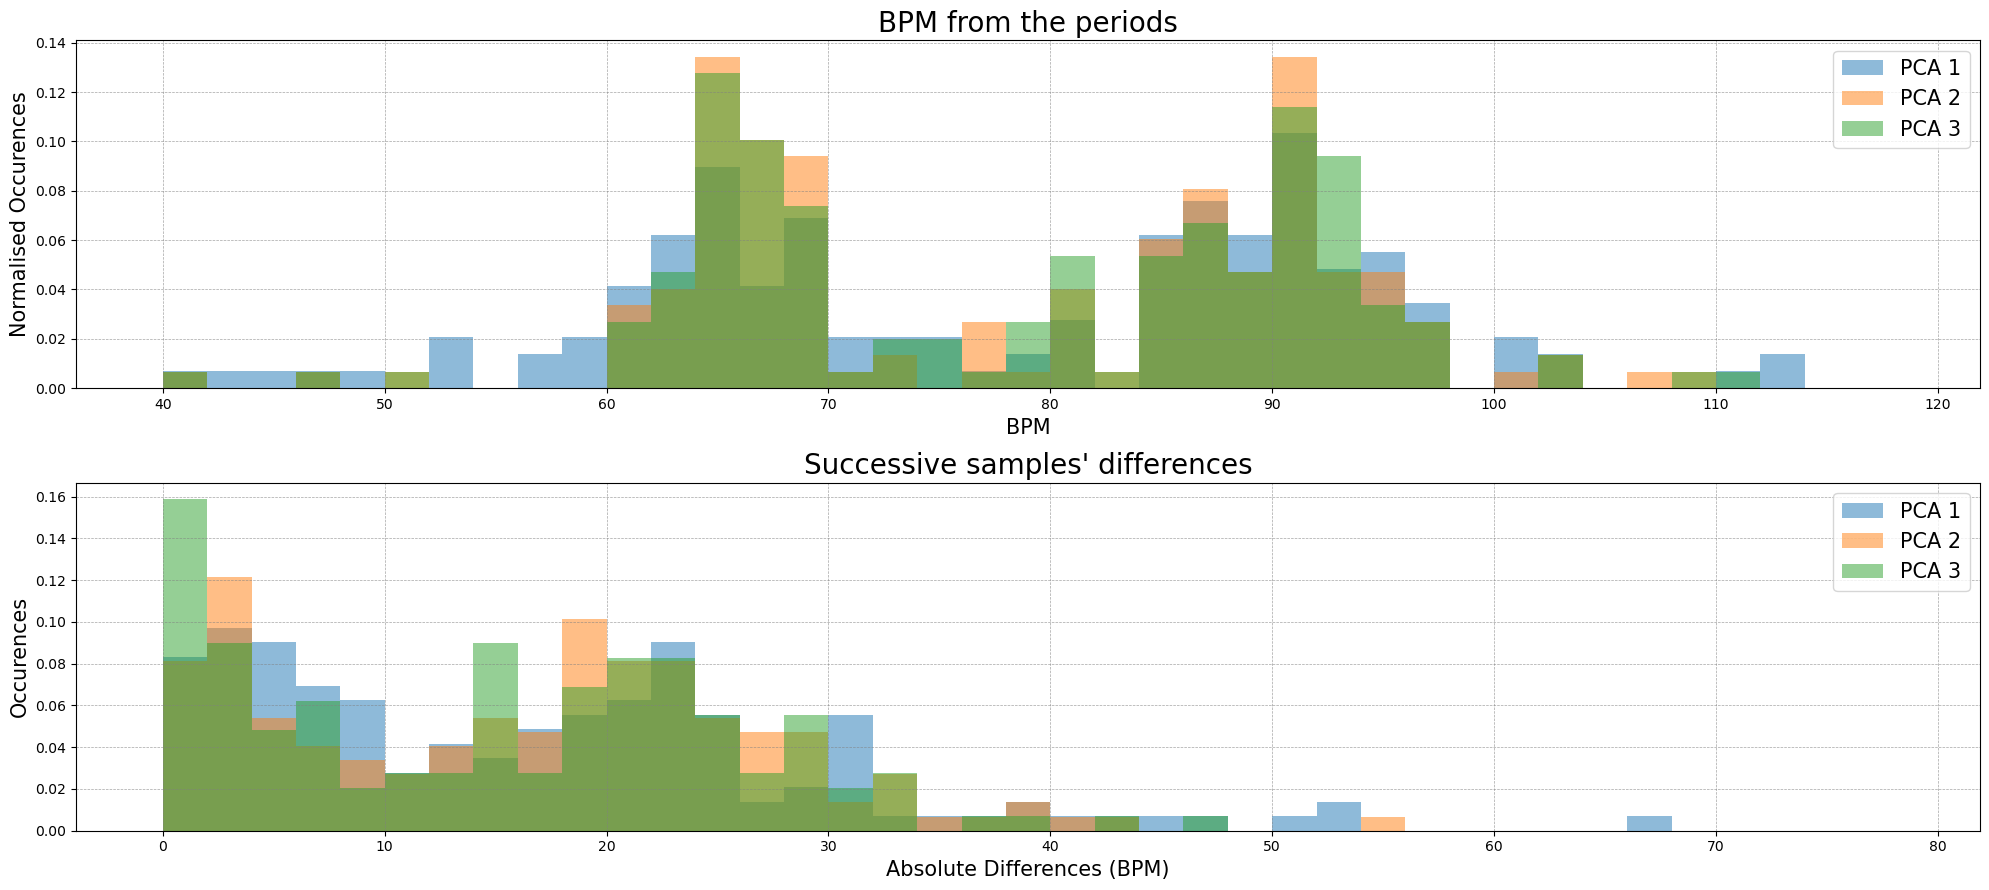

In [39]:
# We only use maxima because using the minima leads to the same results
BPM_naive_list = []
BPM_total = np.array([])
hrv_list = []

# Gaussian Function
gauss = lambda x, A, mu, sigma : A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2)

fig, (ax,bx) = plt.subplots(2,1,figsize=(20,9))

for i in np.arange(filtered_sig.shape[1]):
    min_dis = 20 # Minimum distance between peaks, in number of samples
    
    series = filtered_sig[:,i].real # Define time_series to analyze
    peak_index, _ = signal.find_peaks(series,0.01,distance=min_dis) # Find maxima
    BPM_naive = peak_index.shape[0]/(series.shape[0]/mean_frequency)*60 # Calculate BPM with "naive" method
    BPM_naive_list.append(np.round(BPM_naive,2))

    # We create a histogram of the BPM from the periods between the peaks
    BPM = mean_frequency/np.array([peak_index[i] - peak_index[i-1] for i in range(1,len(peak_index))])*60
    BPM_total = np.concatenate((BPM_total,BPM))
    bin_edges = np.arange(40,120,step=2)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    h = np.histogram(BPM,bins=bin_edges)
    
    # We fit a Gaussian on the Histogram
    hrv = np.sqrt(np.mean(np.diff(BPM)**2)) # Heart Rate Variability
    hrv_list.append(np.round(hrv,2))

    #bx.hist(np.abs(np.diff(BPM)))
    bin_edges = np.arange(0,80,step=2)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    hrv_h = np.histogram(np.abs(np.diff(BPM)),bins=bin_edges)

    
    # Plot
    ax.bar(h[1][0:-1],h[0]/(np.sum(h[0])),align="edge",width=2,alpha=0.5,label="PCA " + str(i+1))
    #ax.plot(np.linspace(30,150,num=120*40), gauss(np.linspace(30,150,num=120*40),*popt), 'k-', lw=2)
    ax.set_title("BPM from the periods", fontsize=20)
    ax.set_xlabel("BPM", fontsize=15)
    ax.set_ylabel("Normalised Occurences", fontsize=15)
    ax.legend(fontsize=15)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

    bx.set_title("Successive samples' differences", fontsize=20)
    bx.set_xlabel("Absolute Differences (BPM)", fontsize=15)
    bx.set_ylabel("Occurences", fontsize=15)
    bx.bar(hrv_h[1][0:-1],hrv_h[0]/(np.sum(hrv_h[0])),align="edge",width=2,alpha=0.5, label="PCA " + str(i+1))
    bx.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    bx.legend(fontsize=15)
    

fig.tight_layout()

    
print(f"These are the BPM from each PCA component: {BPM_naive_list}")
print(f"These are the HRV from each PCA component: {hrv_list}")
wavelet_hrv = np.mean(hrv_list)
wavelet_hrv_std = np.std(hrv_list)

Total number of sample:  454
The center of the gaussian is 79.44 ± 2.85
The width of the gaussian is 17.19 ± 2.9


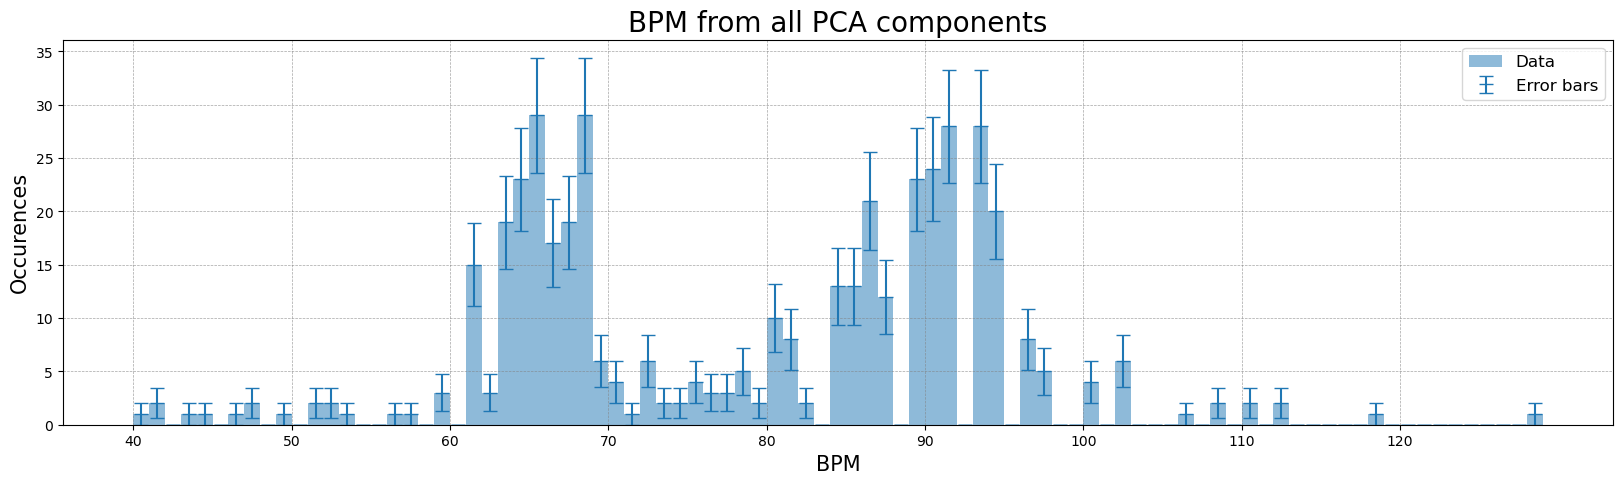

In [40]:
# Total BMP histogram
bin_edges = np.concatenate((np.arange(40,60,step=1),np.arange(60,90,step=1),np.arange(90,130,step=1)))
bin_center = (bin_edges[1:] + bin_edges[:-1])/2
bin_width = bin_edges[1:] - bin_edges[:-1]
h = np.histogram(BPM_total,bins=bin_edges)
popt,pcov = curve_fit(gauss,bin_center,h[0],p0=[10,70,5],maxfev=100000)

print("Total number of sample: ", BPM_total.shape[0])
print(f"The center of the gaussian is {np.round(popt[1],2)} ± {np.round(np.sqrt(pcov[1,1]),2)}")
print(f"The width of the gaussian is {np.round(popt[2],2)} ± {np.round(np.sqrt(pcov[2,2]),2)}")


fig, ax = plt.subplots(figsize=(20,5))
ax.bar(h[1][0:-1],h[0],align="edge",width=bin_width,alpha=0.5, label="Data")
ax.errorbar(bin_center,h[0],np.sqrt(h[0]),ls="None",capsize=5,marker="_",markersize=10, label="Error bars")
ax.set_title("BPM from all PCA components", fontsize=20)
ax.set_xlabel("BPM", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.set_xticks(np.arange(40,126,10))
ax.legend(loc='upper right', fontsize=12);
popt_wavelet = popt
pcov_wavelet = pcov

# Alternative Method
We also implemented another method to extrapolate the BPM from the data, using the fact that heart movement cause both a high linear and angular acceleration. We can see from the data that bot "Acc" and "Gyro" feature present very distinct peaks.
## Subtracting the Baseline
First we subtract the baseline from a feature (here we use "GyroX" as an example, but we can use this method with all features).

In [41]:
def running_mean(x, N):
    """Function to calculate the moving_average"""
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

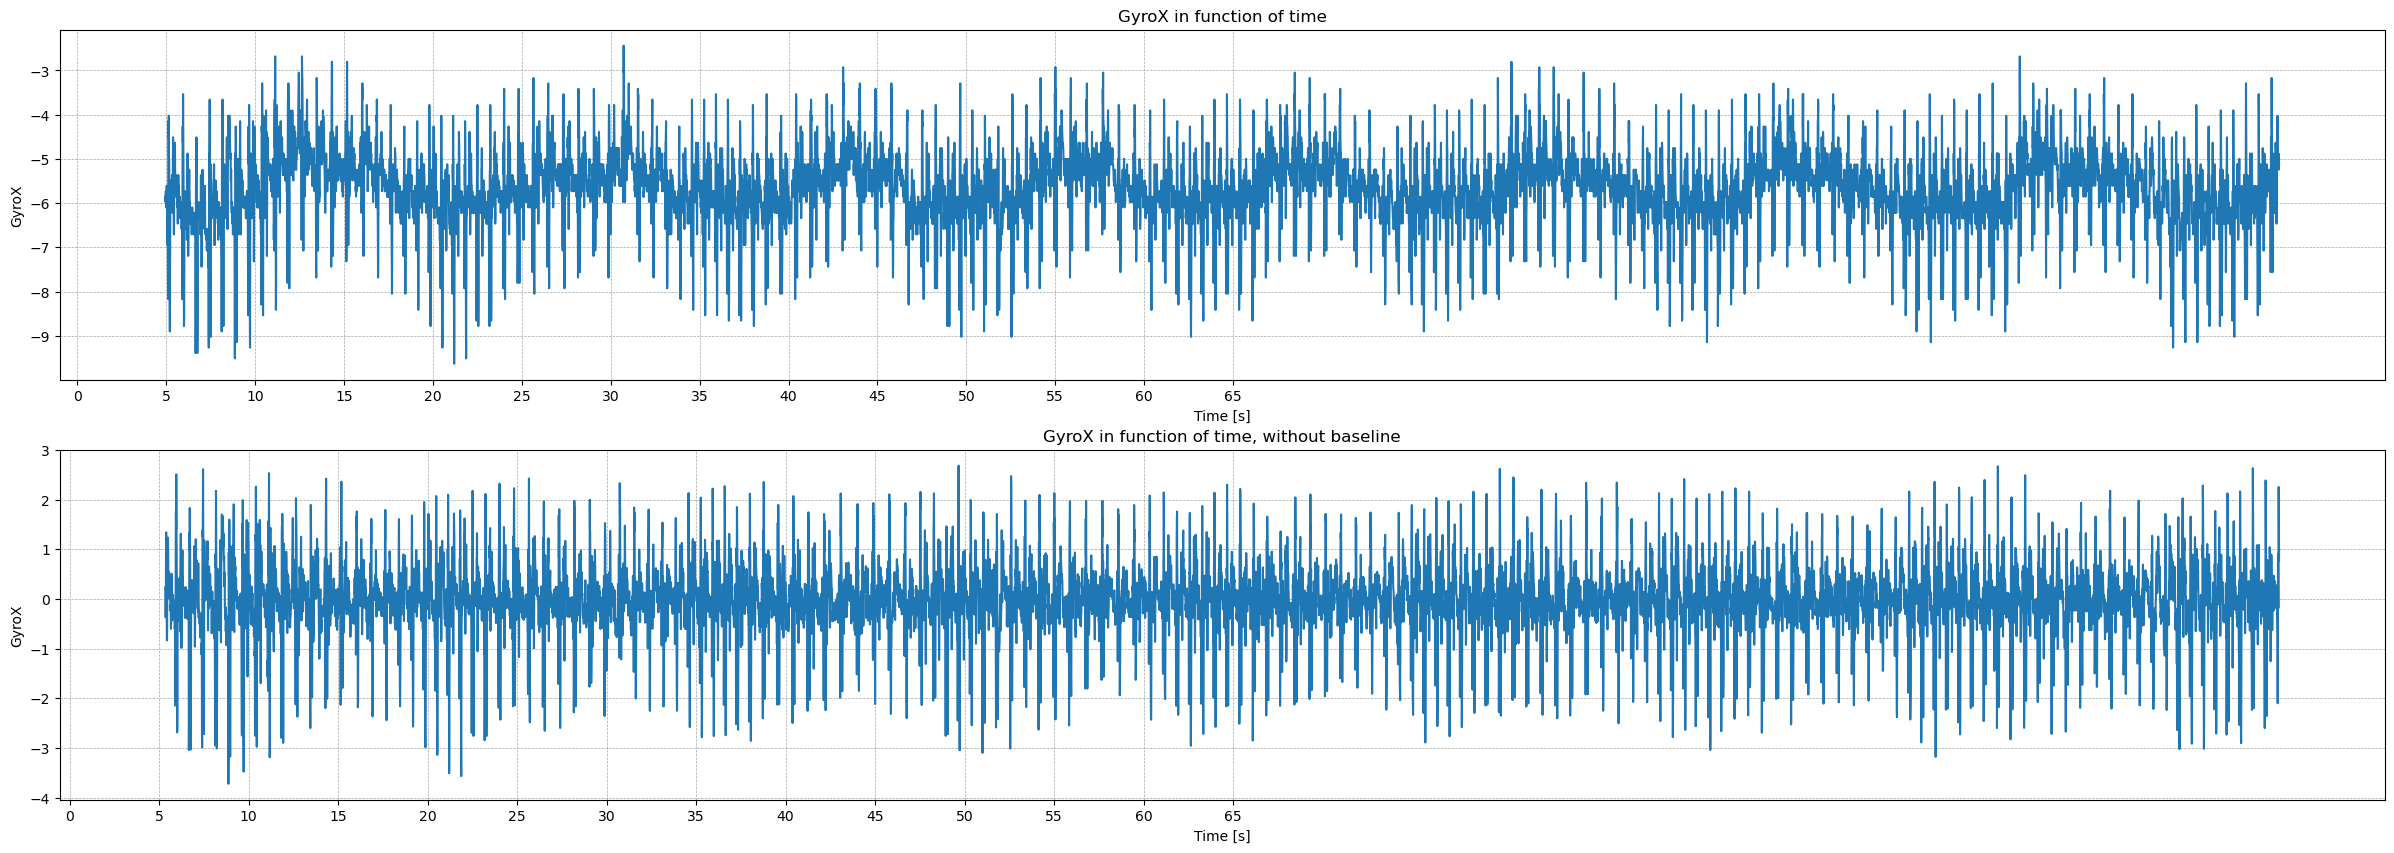

In [42]:
# Plot the data to showcase the low and high frequency component, using "GyroX" time-series as an example

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(30,10))
ax1.plot(cleaned_data["Time"].values, cleaned_data["GyroX"].values)
ax1.set_title("GyroX in function of time")
ax1.set_ylabel("GyroX")
ax1.set_xlabel("Time [s]")
ax1.set_xticks(np.arange(0,70,5))
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

# Calculate the baseline as a moving average
baseline = running_mean(cleaned_data["GyroX"].values,80)
without_baseline = (cleaned_data["GyroX"].values[int(80/2)-1:-int(80/2)] - baseline)

ax2.plot(cleaned_data["Time"][40:-39].values, without_baseline)
ax2.set_title("GyroX in function of time, without baseline")
ax2.set_ylabel("GyroX")
ax2.set_xlabel("Time [s]")
ax2.set_xticks(np.arange(0,70,5))
ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray');


## Finding the peaks
We can analyze the data peaks to extrapolate its frequency.
First we euristically determine a thresold to isolate the peaks, and take care to count only one peak per beat (heart beat has a two peak frequency), as seen in the plot below.
We can also, after having isolated the peaks, plot the histogram of the inverse periods (so the frequencies) of the individual peaks.

BPM computed with naive method is: 74.68


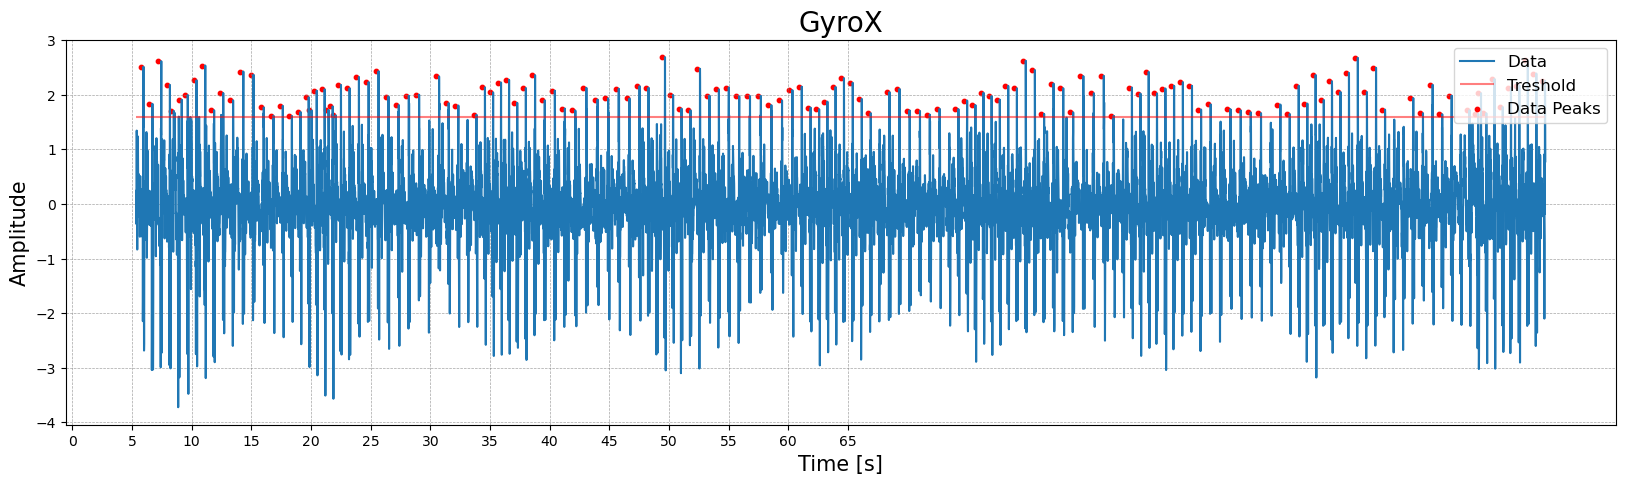

In [43]:
# Results for "GyroX" component
peak_index, _ = signal.find_peaks(without_baseline,1.6,distance=20,) # Find maxima
BPM = peak_index.shape[0]/(without_baseline.shape[0]/mean_frequency)*60 # Calculate BPM with "naive" method
fig, ax = plt.subplots(figsize=(20,5))

ax.set_xlabel("Time [s]", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("GyroX", fontsize=20)
ax.plot(cleaned_data["Time"][40:-39],without_baseline,label="Data")
ax.hlines(1.6,np.min(cleaned_data["Time"][40:-39]),np.max(cleaned_data["Time"][40:-39]),color="red",alpha=0.5,label="Treshold")
ax.scatter(cleaned_data["Time"][peak_index]+0.15,without_baseline[peak_index],c = "red",s=10,label="Data Peaks");
print(f"BPM computed with naive method is: {np.round(BPM,2)}")
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.set_xticks(np.arange(0,70,5))
ax.legend(loc='upper right', fontsize=12);

## Gaussian Fitting

Total number of sample:  454
The center of the gaussian is 78.08 ± 0.88
The width of the gaussian is 8.41 ± 0.89


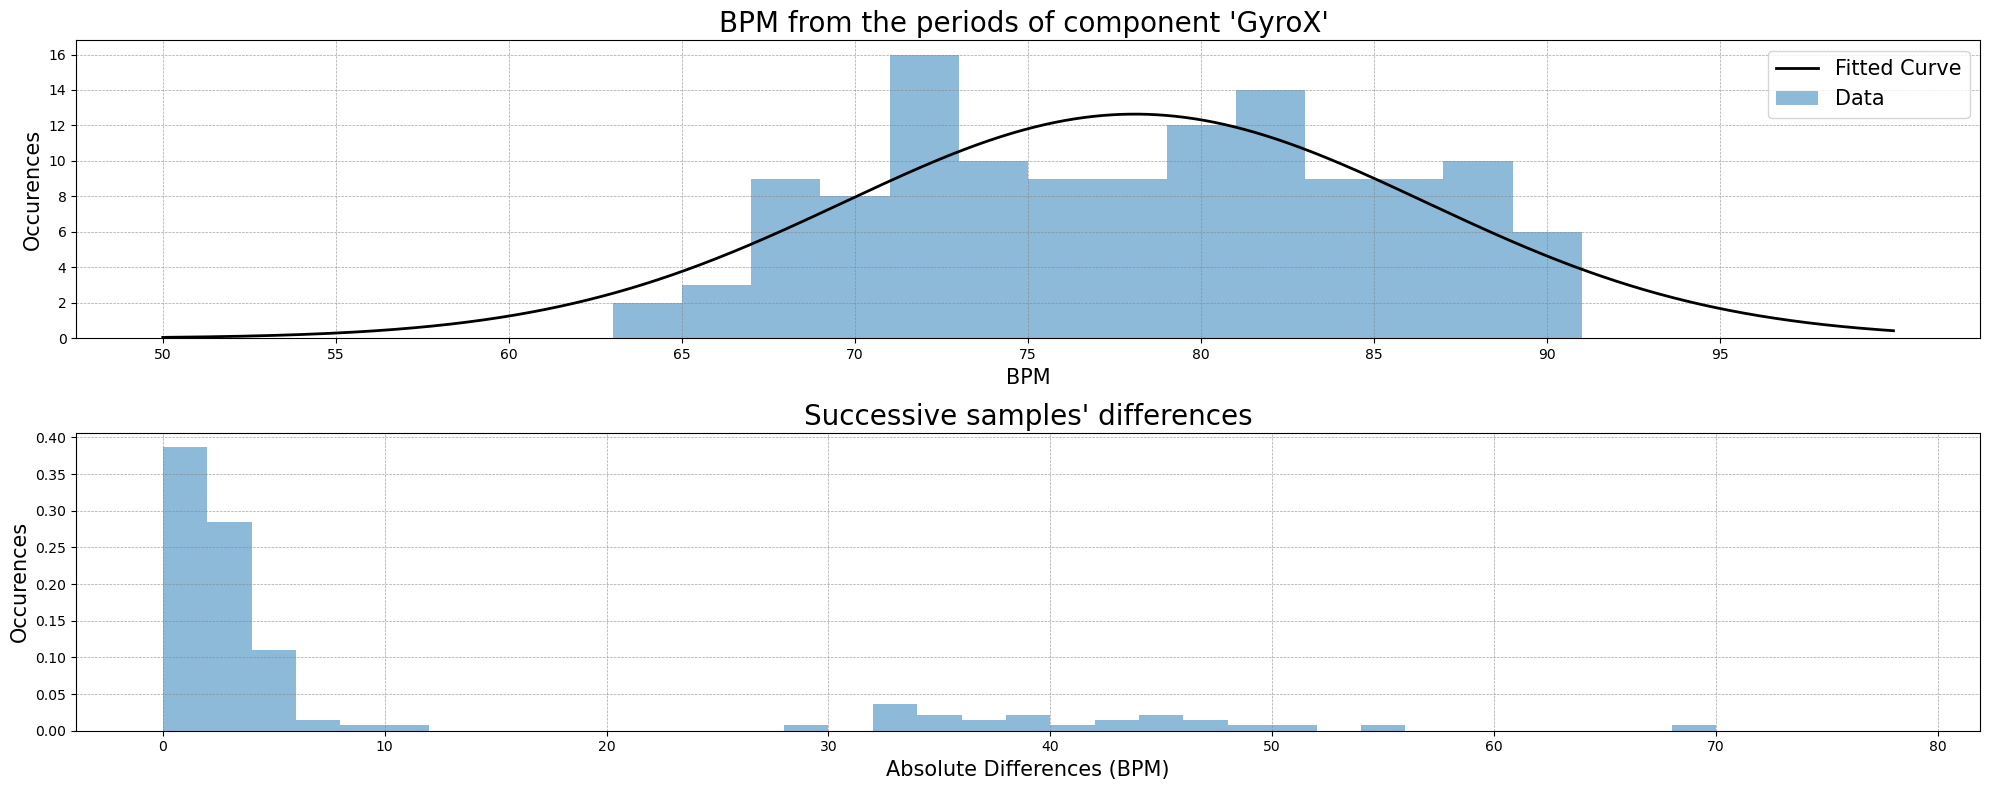

In [44]:
BPM = mean_frequency/np.array([peak_index[i] - peak_index[i-1] for i in range(1,len(peak_index))])*60
bin_edges = np.arange(55,100,step=2)
bin_center = (bin_edges[1:] + bin_edges[:-1])/2
h = np.histogram(BPM,bins=bin_edges)

# We fit a Gaussian on the Histogram
popt,pcov = curve_fit(gauss,bin_center,h[0],p0=[10,75,5])
hrv = np.sqrt(np.mean(np.diff(BPM)**2)) # Heart Rate Variability

# Plot
fig, (ax,bx) = plt.subplots(2,1,figsize=(20, 8))
ax.bar(h[1][0:-1],h[0],align="edge",width=2,alpha=0.5, label="Data")
ax.plot(np.linspace(50,100,num=120*40), gauss(np.linspace(50,100,num=120*40),*popt), 'k-', lw=2, label="Fitted Curve")
ax.set_title("BPM from the periods of component 'GyroX' ", fontsize=20)
ax.set_xlabel("BPM", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.set_xticks(np.arange(50,100,5))
ax.legend(loc='upper right', fontsize=15)
bin_edges = np.arange(0,80,step=2)
bin_center = (bin_edges[1:] + bin_edges[:-1])/2
hrv_h = np.histogram(np.abs(np.diff(BPM)),bins=bin_edges)
bx.set_title("Successive samples' differences", fontsize=20)
bx.set_xlabel("Absolute Differences (BPM)", fontsize=15)
bx.set_ylabel("Occurences", fontsize=15)
bx.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
bx.bar(hrv_h[1][0:-1],hrv_h[0]/(np.sum(hrv_h[0])),align="edge",width=2,alpha=0.5)
fig.tight_layout();

print("Total number of sample: ", BPM_total.shape[0])
print(f"The center of the gaussian is {np.round(popt[1],2)} ± {np.round(np.sqrt(pcov[1,1]),2)}")
print(f"The width of the gaussian is {np.round(popt[2],2)} ± {np.round(np.sqrt(pcov[2,2]),2)}")


popt_alt = popt
pcov_alt = pcov

This method is useful in the way that is robust against noise and setup, but the threshold must be set according to the real-world setup and the physics involved in the data acquisition. The same amplitude cannot be shared among datasets as the maximum amplitude changes according to the position of the subject. After analyzing the dataset, a reasonable threshold can be set and the analysis subsequently performed.
As seen here, we can estimate a BPM of ~74 from the "GyroX" feature, and a similar estimate (with different threshold) can be obtained.


## Respiratory Rate Estimation

We can also try to visualise the heartbeat in function of time

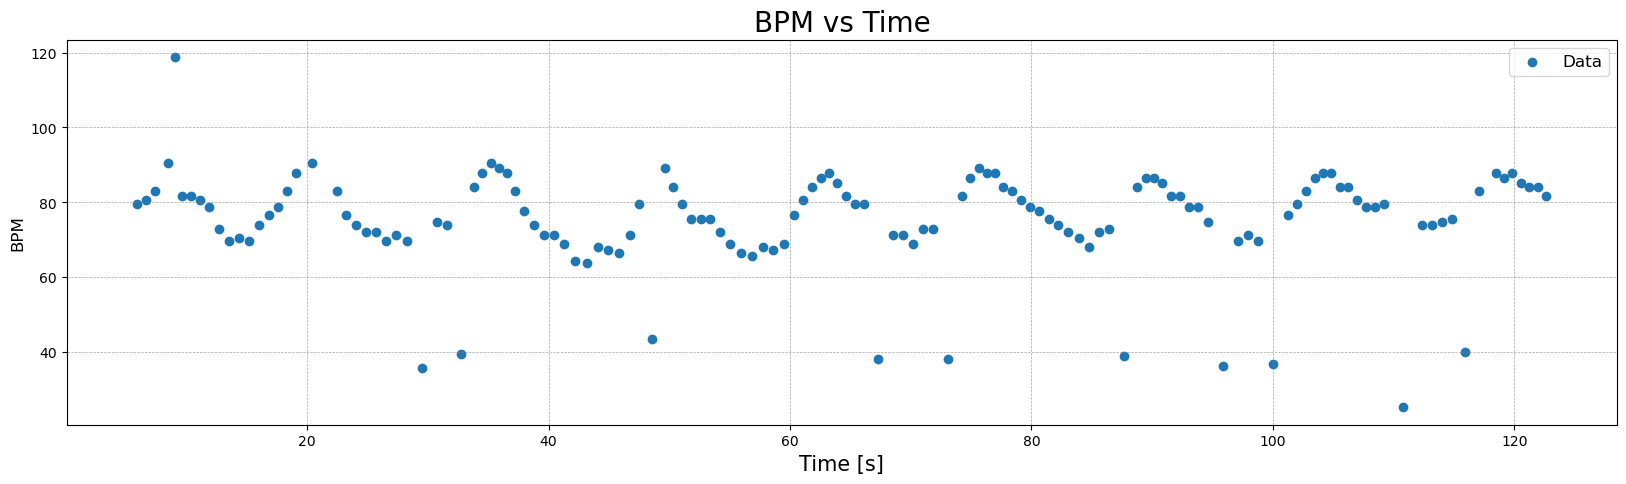

In [45]:
time_center = np.array([(cleaned_data["Time"][peak_index].values[i] + cleaned_data["Time"][peak_index].values[i-1])/2 for i in range(1,len(peak_index))])
widths = np.array([(cleaned_data["Time"][peak_index].values[i] -cleaned_data["Time"][peak_index].values[i-1]) for i in range(1,len(peak_index))])/mean_frequency

fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(time_center[BPM < 120],BPM[BPM < 120],label="Data") # We cut BPM > 120, as they are a product of incorrect peaks
ax.set_ylabel("BPM", fontsize=12)
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_title("BPM vs Time", fontsize=20)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.legend(loc='upper right', fontsize=12);

The BPM in function of time exhibit a sinusoidal shape, and if the frequency of this behaviour is extrapolated, it is found very similar to the Respiratory Rate of a healthy adult at rest (as in our case). That RR is approximatly 12 breaths per minute. Our is ~11.

In [46]:
peak_index, _ = signal.find_peaks(BPM) # Find maxima
RRE = (peak_index.shape[0])/np.max(time_center) * 60 # Naive Method
print(f"The respiratory rate is: {np.round(RRE,2)}")

The respiratory rate is: 12.23


# Conclusions



BPM from Bandpass Method: (79.46±0.39) ± (3.73±0.39)
BPM from Alternative Method: (78.08±0.88) ± (8.41±0.89)
HRV from Bandpass Method: 7.863333333333334 ± 0.6053832578531466
HRV from Alternative Method: 34.125055499612046
Compatibility between Bandpass and Alternative: 0.15


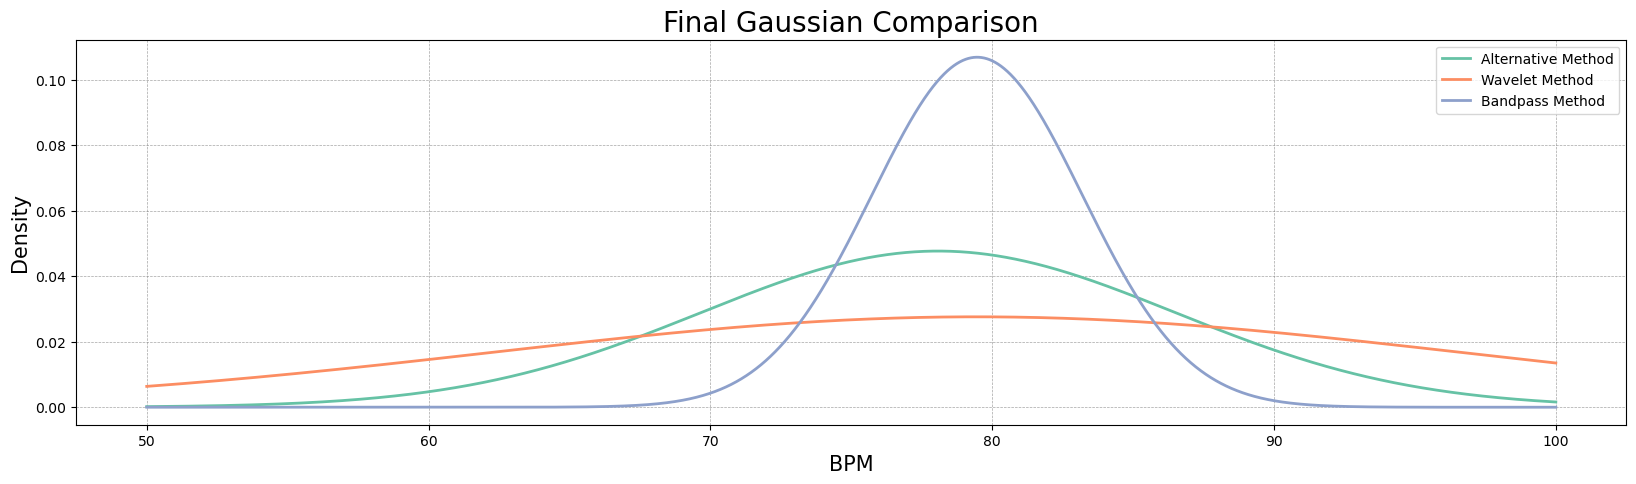

In [47]:
from scipy.integrate import trapz
fig, ax = plt.subplots(figsize=(20,5))

x = np.linspace(50,100,num=120*40)

palette = sns.color_palette("Set2",3)

ax.plot(x, gauss(x,*popt_alt) / trapz(gauss(x,*popt_alt),x), '-', lw=2,label="Alternative Method",color=palette[0])
ax.plot(x, gauss(x,*popt_wavelet) / trapz(gauss(x,*popt_wavelet),x), '-', lw=2,label="Wavelet Method",color=palette[1])
ax.plot(x, gauss(x,*popt_bandpass) / trapz(gauss(x,*popt_bandpass),x), '-', lw=2,label="Bandpass Method",color=palette[2]);
ax.set_xlabel("BPM", fontsize=15)
ax.set_ylabel("Density", fontsize=15)
ax.set_title("Final Gaussian Comparison", fontsize=20)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.legend();

print(f"BPM from Bandpass Method: ({np.round(popt_bandpass[1], 2)}±{np.round(np.sqrt(pcov_bandpass[1,1]),2)}) ± ({np.round(popt_bandpass[2], 2)}±{np.round(np.sqrt(pcov_bandpass[2,2]),2)})")
print(f"BPM from Alternative Method: ({np.round(popt_alt[1], 2)}±{np.round(np.sqrt(pcov_alt[1,1]),2)}) ± ({np.round(popt_alt[2], 2)}±{np.round(np.sqrt(pcov_alt[2,2]),2)})")

print(f"HRV from Bandpass Method:", passband_hrv,"±",passband_hrv_std)
print(f"HRV from Alternative Method:", hrv)


def Compat(popt1,popt2):
    return np.abs(popt1[1] - popt2[1])/(np.sqrt(popt1[2]**2 + popt2[2]**2))


print(f"Compatibility between Bandpass and Alternative: {np.round(Compat(popt_bandpass,popt_alt),2)}")

As we can see from the graph above, the different methods lead to slightly different estimates for BPM. The compatibility test confirmed the compatibility between the different estimates and our final opinion is that the Bandpass method is the best when applicable, and the alternative method when not possible.

When it comes down to the heart rate variability instead, it's harder to pinpoint the correct way to estimate it, as both the wavelet and alternative methods give results incompatible with the passband.